get the feature dataset first by preprocess.py

and replace the filename before load the dataset

# Install and import

## pip

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 11.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=05ea81efe1011cf904db4afb847aeed4c0f68557890f4b056dd388359cfa276e
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 10.5 MB/s eta 0:00:00


In [ ]:
!pip install torch_scatter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch_scatter: filename=torch_scatter-2.1.1-cp310-cp310-linux_x86_64.whl size=489401 sha256=a896dca777ed9eb00d8d1fc95dfe242c12f9bca5ae661e509ab5cd295c991e69
  Stored in directory: /root/.cache/pip/wheels/ef/67/58/6566a3b61c6ec0f2ca0c2c324cd035ef2955601f0fb3197d5f
Successfully built torch_scatter


## import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import torch
import torch_geometric.nn.models.basic_gnn as graph_models
from torch_geometric.nn.models import GCN
from torch_geometric.nn import GCNConv,global_max_pool
from torch_geometric.nn.models import basic_gnn#.BasicGNN
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import torch.sparse
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn as nn
import matplotlib.pyplot as plt
from torchsummary import summary
from torchmetrics.functional import r2_score
import pickle
from torch_scatter import scatter_max

# Models


*   LSTM_GCN
*   GCN_LSTM
*   LSTM
*   GCN



In [ ]:
class LSTM_GCN(nn.Module):
    def __init__(self,num_inputs,num_outputs,hidden_size):
        super(LSTM_GCN,self).__init__()
        self.hidden_size=hidden_size
        self.num_output=num_outputs

        self.lstm=nn.LSTM(input_size=num_inputs,hidden_size=hidden_size,num_layers=20,batch_first=True)
        self.gcn=GCNConv(hidden_size,hidden_size)
        self.fc=nn.Linear(hidden_size,num_outputs)
        self.dropout=nn.Dropout(p=0.1)

    def forward(self,x,edge_index,batch):
        try:
          batch_size,num_nodes,num_features=x.size()
        except:
          batch_size,num_features=x.size()
          num_nodes=1
        x=x.view(batch_size*num_nodes,num_features)
        x,_=self.lstm(x)
        x=x.view(batch_size,num_nodes,self.hidden_size)
        x=F.relu(x)
        x=self.gcn(x, edge_index)
        x=x[:,-1,:]  # Keep only the last timestep
        x=self.fc(x)  # Apply a linear layer to get the desired output size
        x=x.view(batch_size,self.num_output)
        x=self.dropout(x)
        return x

    def predict(self,x,edge_index,batch):
        self.eval()
        return self(x,edge_index,batch)


In [ ]:
class GCN_LSTM(nn.Module):
    def __init__(self,num_inputs,num_outputs,hidden_size):
        super(GCN_LSTM,self).__init__()
        self.hidden_size=hidden_size
        self.num_output=num_outputs

        self.gcn=GCNConv(num_inputs, hidden_size)
        self.lstm=nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=20, batch_first=True)
        self.fc=nn.Linear(hidden_size, num_outputs)
        self.dropout=nn.Dropout(p=0.2)
    def forward(self,x,edge_index,batch):
        x=self.gcn(x,edge_index)
        x=F.relu(x)
        try:
          batch_size,num_nodes,num_features=x.size()
        except:
          batch_size,num_features=x.size()
          num_nodes=1
        x=x.view(batch_size*num_nodes,num_features)
        x,_=self.lstm(x)
        x=x.view(batch_size, num_nodes, self.hidden_size)
        x=x[:,-1,:]  # Keep only the last timestep
        x=self.fc(x)  # Apply a linear layer to get the desired output size
        x=x.view(batch_size,self.num_output)
        x=self.dropout(x)
        return x

    def predict(self,x,edge_index,batch):
        self.eval()
        return self(x,edge_index,batch)


In [ ]:
class LSTM(nn.Module):
    def __init__(self,num_inputs,num_outputs,hidden_size):
        super(LSTM,self).__init__()
        self.hidden_size=hidden_size
        self.num_output=num_outputs

        self.lstm=nn.LSTM(input_size=num_inputs, hidden_size=hidden_size, num_layers=20, batch_first=True)
        self.fc=nn.Linear(hidden_size, num_outputs)
        self.dropout=nn.Dropout(p=0.2)
    def forward(self,x,edge_index,batch):

        try:
          batch_size,num_nodes,num_features=x.size()
        except:
          batch_size,num_features=x.size()
          num_nodes=1
        x=x.view(batch_size*num_nodes,num_features)
        x,_=self.lstm(x)
        x=x.view(batch_size, num_nodes, self.hidden_size)
        x=x[:,-1,:]  # Keep only the last timestep
        x=self.fc(x)  # Apply a linear layer to get the desired output size
        x=x.view(batch_size,self.num_output)
        x=self.dropout(x)
        return x

    def predict(self,x,edge_index,batch):
        self.eval()
        return self(x,edge_index,batch)


In [ ]:
class GCN_3d(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN_3d, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)

        # Reshape x tensor
        num_samples = x.size(0)
        num_nodes = x.size(1)
        hidden_channels = x.size(2)
        x = x.view(-1, hidden_channels)

        # Create batch tensor
        batch_size = x.size(0) // num_nodes
        batch = torch.arange(batch_size).unsqueeze(1).repeat(1, num_nodes).view(-1).to(x.device)

        # Apply max pooling
        x = scatter_max(x, batch, dim=0)[0]

        # Reshape x tensor to desired output shape
        x = x.view(num_samples, -1)

        x = self.fc(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train and test result

## some function for training and test

In [ ]:
def train_test(model,epoch):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=500,factor =0.5 ,min_lr=1e-7, eps=1e-08)
  criterion = torch.nn.MSELoss().to(device)
  num_nodes = 28
  batch_size = 153  # Number of samples in the batch
  num_edges = num_nodes * (num_nodes - 1)

  # Create the edge indices
  row_indices = torch.repeat_interleave(torch.arange(num_nodes), num_nodes - 1)
  col_indices = torch.tensor([j for j in range(num_nodes) for _ in range(num_nodes - 1)])
  edge_index = torch.stack([row_indices, col_indices])

  # Repeat the edge indices for each sample in the batch (size: (2, num_edges, num_samples))
  edge_index = edge_index.unsqueeze(-1).repeat(1, 1, 1530)
  batch = {
      'batch_size': torch.full((batch_size,), num_nodes, dtype=torch.long)
  }
  loss_lst=[]
  val_loss_lst=[]
  last_val_loss = 100
  last_loss = 100
  delta=100
  trigger_times=0
  patience = 2
  for epoch in range(epoch):
    model.train()
    try:
      try:
        outputs=model(X_train,edge_index,batch) # LSTM_GCN, GCN_LSTM
      except: # GCN_3d
        #batch = torch.full((batch_size * num_nodes,), 0, dtype=torch.long)
        #batch = batch.unsqueeze(0).repeat(batch_size, 1)
        batch = torch.arange(X_train.size()[1]).repeat(X_train.size()[0])
        #batch=batch.view(X_train.size()[0],X_train.size()[1],1)
        batch=batch.to(device)
        #batch = batch.view(-1)
        outputs=model(X_train,edge_index,batch)

    except:
      outputs=model(X_train,edge_index)
    #torch.empty(2, 0, dtype=torch.long).to(device)
    optimizer.zero_grad()
    #print("output ",outputs.size()) #torch.Size([22989460, 1])
    #print("y ",y_train.size()) #torch.Size([1885, 12196])

    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # validation
    model.eval()
    try:
      val=model(X_val,edge_index,batch)
    except:
      val=model(X_val,edge_index)
    #print("val size ",val.size(), " val_y ",y_val.size())
    val_loss=criterion(val, y_val)
    scheduler.step(val_loss)
    loss_lst.append(loss.cpu().item())
    val_loss_lst.append(val_loss.cpu().item())
    print("Epoch: %d, loss: %1.5f val_loss %1.5f" %(epoch, loss.cpu().item(),val_loss.cpu().item()))
    if (val_loss_lst[-1] > last_val_loss or loss_lst[-1]>last_loss) and abs(val_loss_lst[-1]-loss_lst[-1])>delta:
      trigger_times += 1
      if trigger_times >= patience:
          print('Early stopping at epoch {}!'.format(epoch))
          break
    last_val_loss=val_loss_lst[-1]
    last_loss=loss_lst[-1]
    delta=min(delta,abs(val_loss_lst[-1]-loss_lst[-1]))

  return model, loss_lst, val_loss_lst, edge_index, batch

In [ ]:
def test(model,edge_index,batch):
  try:
    pred=model(X_test,edge_index,batch) # LSTM_GCN, GCN_LSTM
  except:
    pred=model(X_test,edge_index) #GCN
  criterion = torch.nn.MSELoss().to(device)
  score=criterion(pred,y_test)
  return score.cpu().item(), r2_score(pred,y_test).cpu().item()

In [ ]:
def loss_plot(loss,val_loss):
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(["loss","val_loss"])
  plt.show()

## time features

### load_data

In [ ]:
time_feature=pd.read_csv("drive/MyDrive/m5/df_time.csv")
time_feature.head()

,0,1,2,3,4,5,6,7,8,9,...,30492,30493,30494,30495,30496,30497,30498,30499,30500,30501
0,2011,1,29.0,1.0,1,1.0,1.0,1.0,1.0,0,...,0,14,1,0,4,0,0,0,0,0
1,2011,1,30.0,2.0,2,1.0,1.0,1.0,1.0,0,...,0,11,1,0,4,0,0,6,0,0
2,2011,1,31.0,3.0,3,1.0,1.0,1.0,1.0,0,...,0,5,1,0,2,2,0,0,0,0
3,2011,2,1.0,4.0,4,1.0,1.0,1.0,1.0,1,...,0,6,1,0,5,2,0,2,0,0
4,2011,2,2.0,5.0,5,1.0,1.0,1.0,1.0,1,...,0,5,1,0,2,0,0,2,0,0


In [ ]:
sc = MinMaxScaler(feature_range=(-1, 1))
time_feature.iloc[:-56,:]=sc.fit_transform(time_feature.iloc[:-56,:])
time_feature.iloc[-56:,:]=sc.transform(time_feature.iloc[-56:,:])

In [ ]:
time_feature.to_csv("drive/MyDrive/m5/df_time_norm.csv",index=False)

In [ ]:
#time_feature=pd.read_csv("drive/MyDrive/m5/df_time_norm.csv")
#time_feature.head()

In [ ]:
X_train=torch.FloatTensor(np.array(time_feature.iloc[:-56,:12])).to(device)
y_train=torch.FloatTensor(np.array(time_feature.iloc[:-56,12:])).to(device)
X_val=torch.FloatTensor(np.array(time_feature.iloc[-56:-28,:12])).to(device)
y_val=torch.FloatTensor(np.array(time_feature.iloc[-56:-28,12:])).to(device)
X_test=torch.FloatTensor(np.array(time_feature.iloc[-28:,:12])).to(device)
y_test=torch.FloatTensor(np.array(time_feature.iloc[-28:,12:])).to(device)

In [ ]:
X_train.shape, y_train.shape

(torch.Size([1885, 12]), torch.Size([1885, 30490]))

### LSTM_GCN

In [ ]:
model_lstm_gcn=LSTM_GCN(num_inputs=X_train.shape[1],num_outputs=y_train.shape[1],hidden_size=153) # ,num_nodes=train_X.shape[2]
model_lstm_gcn.to(device)

LSTM_GCN(
  (lstm): LSTM(12, 153, num_layers=20, batch_first=True)
  (gcn): GCNConv(153, 153)
  (fc): Linear(in_features=153, out_features=30490, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_lstm_gcn,100)

Epoch: 0, loss: 0.81944 val_loss 0.74287
Epoch: 1, loss: 0.81344 val_loss 0.73556
Epoch: 2, loss: 0.80518 val_loss 0.72468
Epoch: 3, loss: 0.79263 val_loss 0.70882
Epoch: 4, loss: 0.77393 val_loss 0.68542
Epoch: 5, loss: 0.74555 val_loss 0.64996
Epoch: 6, loss: 0.70092 val_loss 0.59409
Epoch: 7, loss: 0.62695 val_loss 0.50477
Epoch: 8, loss: 0.50193 val_loss 0.37863
Epoch: 9, loss: 0.33051 val_loss 0.28869
Epoch: 10, loss: 0.28612 val_loss 0.27207
Epoch: 11, loss: 0.31181 val_loss 0.23866
Epoch: 12, loss: 0.25810 val_loss 0.20884
Epoch: 13, loss: 0.19838 val_loss 0.19636
Epoch: 14, loss: 0.16744 val_loss 0.19574
Epoch: 15, loss: 0.16023 val_loss 0.19679
Early stopping at epoch 15!
CPU times: user 1min 22s, sys: 14.1 s, total: 1min 36s
Wall time: 1min 38s


In [ ]:
loss

[0.8194378614425659,
 0.8134443759918213,
 0.8051801323890686,
 0.7926272749900818,
 0.7739343643188477,
 0.7455511689186096,
 0.700918436050415,
 0.6269538998603821,
 0.5019273161888123,
 0.33050912618637085,
 0.28611692786216736,
 0.31180787086486816,
 0.2580965757369995,
 0.19837860763072968,
 0.16743986308574677,
 0.1602293998003006]

In [ ]:
val_loss

[0.7428723573684692,
 0.7355576753616333,
 0.7246777415275574,
 0.7088227272033691,
 0.6854181289672852,
 0.649959146976471,
 0.5940902233123779,
 0.5047662258148193,
 0.37863287329673767,
 0.28869128227233887,
 0.2720702886581421,
 0.23865745961666107,
 0.20884427428245544,
 0.19636407494544983,
 0.19573602080345154,
 0.19678601622581482]

test mse	0.1977611929178238
test r2	-13.802024841308594


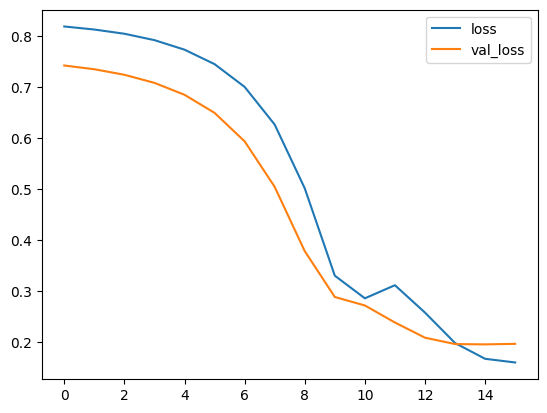

In [ ]:
result=test(model_lstm_gcn,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

### GCN_LSTM

In [ ]:
model_gcn_lstm=GCN_LSTM(num_inputs=X_train.shape[1],num_outputs=y_train.shape[1],hidden_size=153) # ,num_nodes=train_X.shape[2]
model_gcn_lstm.to(device)

GCN_LSTM(
  (gcn): GCNConv(12, 153)
  (lstm): LSTM(153, 153, num_layers=20, batch_first=True)
  (fc): Linear(in_features=153, out_features=30490, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_gcn_lstm,100)

Epoch: 0, loss: 0.82040 val_loss 0.74083
Epoch: 1, loss: 0.81137 val_loss 0.73103
Epoch: 2, loss: 0.80027 val_loss 0.71779
Epoch: 3, loss: 0.78492 val_loss 0.69929
Epoch: 4, loss: 0.76284 val_loss 0.67228
Epoch: 5, loss: 0.72935 val_loss 0.63033
Epoch: 6, loss: 0.67430 val_loss 0.56121
Epoch: 7, loss: 0.57712 val_loss 0.45186
Epoch: 8, loss: 0.42547 val_loss 0.33014
Epoch: 9, loss: 0.32870 val_loss 0.27631
Epoch: 10, loss: 0.36644 val_loss 0.24783
Epoch: 11, loss: 0.34776 val_loss 0.22274
Epoch: 12, loss: 0.29946 val_loss 0.20776
Epoch: 13, loss: 0.25662 val_loss 0.20403
Epoch: 14, loss: 0.23245 val_loss 0.20714
Epoch: 15, loss: 0.22417 val_loss 0.21187
Epoch: 16, loss: 0.22423 val_loss 0.21497
Epoch: 17, loss: 0.22666 val_loss 0.21523
Early stopping at epoch 17!
CPU times: user 1min 34s, sys: 15.4 s, total: 1min 49s
Wall time: 1min 50s


In [ ]:
loss

[0.8203999400138855,
 0.8113732933998108,
 0.8002733588218689,
 0.7849218249320984,
 0.7628355026245117,
 0.7293485999107361,
 0.6743013858795166,
 0.5771183967590332,
 0.4254734516143799,
 0.3287011384963989,
 0.3664429187774658,
 0.3477620482444763,
 0.29945746064186096,
 0.25662216544151306,
 0.2324478030204773,
 0.22416523098945618,
 0.2242327779531479,
 0.22666071355342865]

In [ ]:
val_loss

[0.740825891494751,
 0.7310342788696289,
 0.717789351940155,
 0.699287474155426,
 0.6722806692123413,
 0.6303265690803528,
 0.5612097382545471,
 0.4518551528453827,
 0.33013880252838135,
 0.27631017565727234,
 0.247831329703331,
 0.22274211049079895,
 0.2077590376138687,
 0.20403344929218292,
 0.2071378231048584,
 0.21187351644039154,
 0.21497274935245514,
 0.21522605419158936]

test mse	0.21559607982635498
test r2	-15.849441528320312


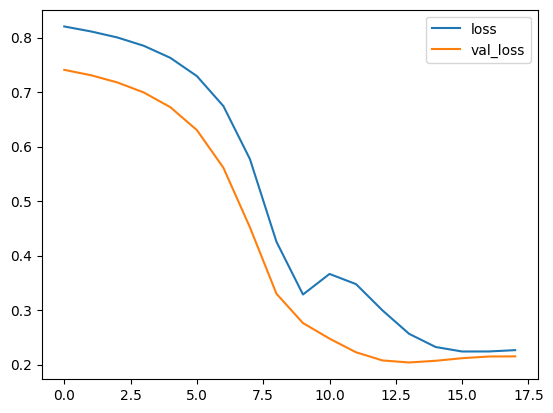

In [ ]:
result=test(model_gcn_lstm,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

### GCN

In [ ]:
model_gcn=GCN(in_channels=X_train.shape[1],hidden_channels=y_train.shape[1],num_layers=1) # ,num_nodes=train_X.shape[2]
model_gcn.to(device)

GCN(12, 30490, num_layers=1)

In [ ]:
X_train.shape[1]

12

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_gcn,100)

Epoch: 0, loss: 0.81750 val_loss 0.73861
Epoch: 1, loss: 0.80697 val_loss 0.73045
Epoch: 2, loss: 0.79654 val_loss 0.72234
Epoch: 3, loss: 0.78619 val_loss 0.71427
Epoch: 4, loss: 0.77593 val_loss 0.70624
Epoch: 5, loss: 0.76576 val_loss 0.69826
Epoch: 6, loss: 0.75568 val_loss 0.69033
Epoch: 7, loss: 0.74570 val_loss 0.68245
Epoch: 8, loss: 0.73580 val_loss 0.67461
Epoch: 9, loss: 0.72600 val_loss 0.66683
Epoch: 10, loss: 0.71630 val_loss 0.65910
Epoch: 11, loss: 0.70669 val_loss 0.65142
Epoch: 12, loss: 0.69718 val_loss 0.64380
Epoch: 13, loss: 0.68777 val_loss 0.63624
Epoch: 14, loss: 0.67846 val_loss 0.62873
Epoch: 15, loss: 0.66924 val_loss 0.62129
Epoch: 16, loss: 0.66013 val_loss 0.61390
Epoch: 17, loss: 0.65112 val_loss 0.60658
Epoch: 18, loss: 0.64220 val_loss 0.59932
Epoch: 19, loss: 0.63339 val_loss 0.59213
Epoch: 20, loss: 0.62468 val_loss 0.58500
Epoch: 21, loss: 0.61607 val_loss 0.57794
Epoch: 22, loss: 0.60757 val_loss 0.57094
Epoch: 23, loss: 0.59916 val_loss 0.56402
Ep

In [ ]:
loss

[0.8174952268600464,
 0.8069738149642944,
 0.7965382933616638,
 0.7861899137496948,
 0.7759303450584412,
 0.7657605409622192,
 0.7556818127632141,
 0.7456954717636108,
 0.735802412033081,
 0.7260037660598755,
 0.716300368309021,
 0.7066935300827026,
 0.6971836686134338,
 0.6877719163894653,
 0.6784586310386658,
 0.6692448258399963,
 0.6601308584213257,
 0.6511172652244568,
 0.6422045230865479,
 0.6333931088447571,
 0.6246830821037292,
 0.6160749197006226,
 0.6075686812400818,
 0.5991644263267517,
 0.5908623933792114,
 0.5826622843742371,
 0.5745642781257629,
 0.5665681958198547,
 0.5586736798286438,
 0.5508806705474854,
 0.5431888103485107,
 0.5355978012084961,
 0.5281071662902832,
 0.5207165479660034,
 0.5134254097938538,
 0.506233274936676,
 0.49913957715034485,
 0.4921436905860901,
 0.485245019197464,
 0.4784429669380188,
 0.4717368185520172,
 0.46512579917907715,
 0.4586092531681061,
 0.4521862864494324,
 0.44585633277893066,
 0.4396183490753174,
 0.4334717094898224,
 0.42741546034

In [ ]:
val_loss

[0.7386125326156616,
 0.7304524779319763,
 0.7223366498947144,
 0.7142657041549683,
 0.7062402367591858,
 0.6982612013816833,
 0.690329372882843,
 0.6824459433555603,
 0.6746121644973755,
 0.6668294072151184,
 0.6590991020202637,
 0.6514227390289307,
 0.6438016891479492,
 0.6362376809120178,
 0.6287319660186768,
 0.6212859749794006,
 0.6139010190963745,
 0.6065784692764282,
 0.5993195176124573,
 0.5921253561973572,
 0.5849969983100891,
 0.5779353976249695,
 0.5709415674209595,
 0.5640162229537964,
 0.5571600794792175,
 0.5503738522529602,
 0.5436580181121826,
 0.5370131731033325,
 0.5304396152496338,
 0.5239377021789551,
 0.517507791519165,
 0.5111499428749084,
 0.5048643350601196,
 0.49865108728408813,
 0.4925101697444916,
 0.48644158244132996,
 0.4804452955722809,
 0.47452104091644287,
 0.4686686396598816,
 0.4628879427909851,
 0.4571787416934967,
 0.45154061913490295,
 0.44597330689430237,
 0.44047650694847107,
 0.4350496530532837,
 0.4296925365924835,
 0.4244045913219452,
 0.419185

test mse	0.24527223408222198
test r2	-17.397550582885742


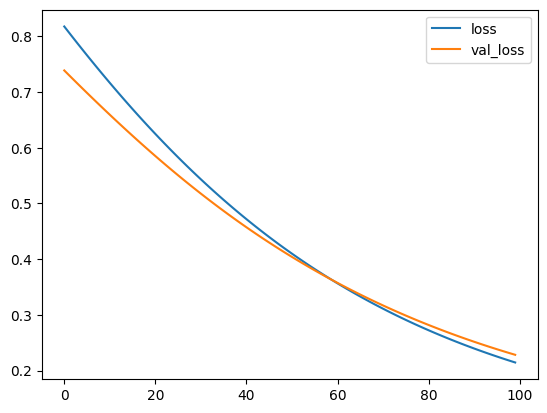

In [ ]:
result=test(model_gcn,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

### LSTM

In [ ]:
model_lstm=LSTM(num_inputs=X_train.shape[1],num_outputs=y_train.shape[1],hidden_size=153) # ,num_nodes=train_X.shape[2]
model_lstm.to(device)

LSTM(
  (lstm): LSTM(12, 153, num_layers=20, batch_first=True)
  (fc): Linear(in_features=153, out_features=30490, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_lstm,100)

Epoch: 0, loss: 0.82054 val_loss 0.74116
Epoch: 1, loss: 0.81182 val_loss 0.73197
Epoch: 2, loss: 0.80152 val_loss 0.71973
Epoch: 3, loss: 0.78755 val_loss 0.70303
Epoch: 4, loss: 0.76802 val_loss 0.67931
Epoch: 5, loss: 0.73942 val_loss 0.64361
Epoch: 6, loss: 0.69440 val_loss 0.58591
Epoch: 7, loss: 0.61687 val_loss 0.48922
Epoch: 8, loss: 0.47873 val_loss 0.35543
Epoch: 9, loss: 0.32871 val_loss 0.28233
Epoch: 10, loss: 0.38634 val_loss 0.25503
Epoch: 11, loss: 0.36956 val_loss 0.22904
Epoch: 12, loss: 0.30952 val_loss 0.21536
Epoch: 13, loss: 0.25811 val_loss 0.21528
Epoch: 14, loss: 0.23287 val_loss 0.22184
Epoch: 15, loss: 0.22709 val_loss 0.22777
Epoch: 16, loss: 0.22906 val_loss 0.22939
Epoch: 17, loss: 0.23132 val_loss 0.22633
Early stopping at epoch 17!
CPU times: user 1min 37s, sys: 17.8 s, total: 1min 55s
Wall time: 1min 58s


In [ ]:
loss

[0.8205423951148987,
 0.8118237257003784,
 0.8015215396881104,
 0.7875507473945618,
 0.7680168747901917,
 0.739415168762207,
 0.6944049000740051,
 0.6168676614761353,
 0.47873231768608093,
 0.3287079632282257,
 0.386342853307724,
 0.3695593476295471,
 0.30952078104019165,
 0.2581120431423187,
 0.23286664485931396,
 0.2270861566066742,
 0.22906267642974854,
 0.2313222885131836]

In [ ]:
val_loss

[0.7411643862724304,
 0.7319678664207458,
 0.7197309136390686,
 0.7030314207077026,
 0.6793087124824524,
 0.6436067819595337,
 0.5859102010726929,
 0.4892178177833557,
 0.35542765259742737,
 0.2823311388492584,
 0.25502827763557434,
 0.22904275357723236,
 0.21535757184028625,
 0.21528074145317078,
 0.2218438982963562,
 0.22777190804481506,
 0.22939175367355347,
 0.22633486986160278]

test mse	0.22636628150939941
test r2	-16.391054153442383


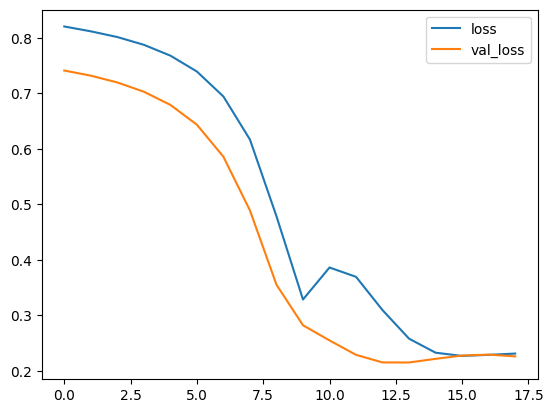

In [ ]:
result=test(model_lstm,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

## statistic

### load_data

In [ ]:
stat_feature=pd.read_csv("drive/MyDrive/m5/statistic_HOBBIES_1_004_CA_1.csv")
stat_feature.head(10)

,HOBBIES_1_004_CA_1,min_value,max_value,mean_value
0,0,NaN,NaN,NaN
1,0,NaN,NaN,NaN
2,0,NaN,NaN,NaN
3,0,NaN,NaN,NaN
4,0,NaN,NaN,NaN
5,0,NaN,NaN,NaN
6,0,NaN,NaN,NaN
7,0,0.0,0.0,0.0
8,0,0.0,0.0,0.0
9,0,0.0,0.0,0.0


In [ ]:
sc = MinMaxScaler(feature_range=(-1, 1))
stat_feature.iloc[7:-56,:]=sc.fit_transform(stat_feature.iloc[7:-56,:])
stat_feature.iloc[-56:,:]=sc.transform(stat_feature.iloc[-56:,:])

In [ ]:
stat_feature.to_csv("drive/MyDrive/m5/statistic_HOBBIES_1_004_CA_1_norm.csv",index=False)

In [ ]:
X_train=torch.FloatTensor(np.array(stat_feature.iloc[7:-56,:3])).to(device)
y_train=torch.FloatTensor(np.array(stat_feature.iloc[7:-56,3:])).to(device)
X_val=torch.FloatTensor(np.array(stat_feature.iloc[-56:-28,:3])).to(device)
y_val=torch.FloatTensor(np.array(stat_feature.iloc[-56:-28,3:])).to(device)
X_test=torch.FloatTensor(np.array(stat_feature.iloc[-28:,:3])).to(device)
y_test=torch.FloatTensor(np.array(stat_feature.iloc[-28:,3:])).to(device)

In [ ]:
X_train.shape, y_train.shape

(torch.Size([1878, 3]), torch.Size([1878, 1]))

### LSTN_GCN

In [ ]:
model_lstm_gcn=LSTM_GCN(num_inputs=X_train.shape[1],num_outputs=y_train.shape[1],hidden_size=153) # ,num_nodes=train_X.shape[2]
model_lstm_gcn.to(device)

LSTM_GCN(
  (lstm): LSTM(3, 153, num_layers=20, batch_first=True)
  (gcn): GCNConv(153, 153)
  (fc): Linear(in_features=153, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_lstm_gcn,100)

Epoch: 0, loss: 0.18681 val_loss 0.07778
Epoch: 1, loss: 0.17027 val_loss 0.07829
Epoch: 2, loss: 0.16221 val_loss 0.08607
Epoch: 3, loss: 0.16246 val_loss 0.09132
Epoch: 4, loss: 0.16764 val_loss 0.08948
Epoch: 5, loss: 0.16234 val_loss 0.08652
Epoch: 6, loss: 0.15983 val_loss 0.08440
Epoch: 7, loss: 0.15902 val_loss 0.08321
Epoch: 8, loss: 0.16025 val_loss 0.08270
Early stopping at epoch 8!
CPU times: user 15.9 s, sys: 1.91 s, total: 17.8 s
Wall time: 19.2 s


In [ ]:
loss

[0.18680690228939056,
 0.1702674776315689,
 0.16220663487911224,
 0.1624622642993927,
 0.1676398664712906,
 0.1623413860797882,
 0.159834086894989,
 0.15901575982570648,
 0.16024920344352722]

In [ ]:
val_loss

[0.0777754932641983,
 0.0782892182469368,
 0.0860685333609581,
 0.091324582695961,
 0.08948291838169098,
 0.08652322739362717,
 0.08440207690000534,
 0.08320873975753784,
 0.08270357549190521]

test mse	0.04159611836075783
test r2	0.03287792205810547


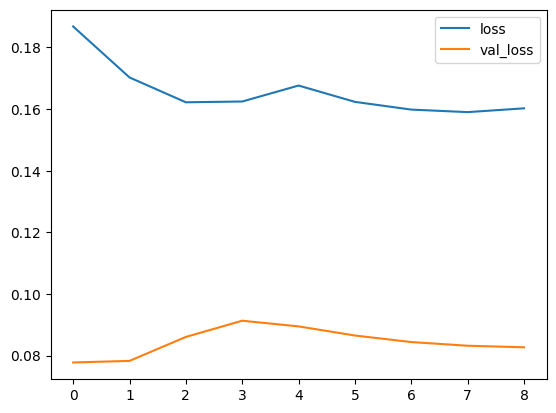

In [ ]:
result=test(model_lstm_gcn,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

### GCN_LSTM

In [ ]:
model_gcn_lstm=GCN_LSTM(num_inputs=X_train.shape[1],num_outputs=y_train.shape[1],hidden_size=153) # ,num_nodes=train_X.shape[2]
model_gcn_lstm.to(device)

GCN_LSTM(
  (gcn): GCNConv(3, 153)
  (lstm): LSTM(153, 153, num_layers=20, batch_first=True)
  (fc): Linear(in_features=153, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_gcn_lstm,100)

Epoch: 0, loss: 0.19364 val_loss 0.07769
Epoch: 1, loss: 0.17637 val_loss 0.07484
Epoch: 2, loss: 0.16718 val_loss 0.07814
Epoch: 3, loss: 0.16222 val_loss 0.08337
Epoch: 4, loss: 0.16893 val_loss 0.08239
Epoch: 5, loss: 0.17095 val_loss 0.07983
Early stopping at epoch 5!
CPU times: user 9.95 s, sys: 528 ms, total: 10.5 s
Wall time: 10.7 s


In [ ]:
loss

[0.19364330172538757,
 0.17637233436107635,
 0.16718463599681854,
 0.16222167015075684,
 0.16892829537391663,
 0.1709519922733307]

In [ ]:
val_loss

[0.077691450715065,
 0.07483923435211182,
 0.07814101129770279,
 0.08336861431598663,
 0.08238973468542099,
 0.07982806116342545]

test mse	0.038716111332178116
test r2	0.09983891248703003


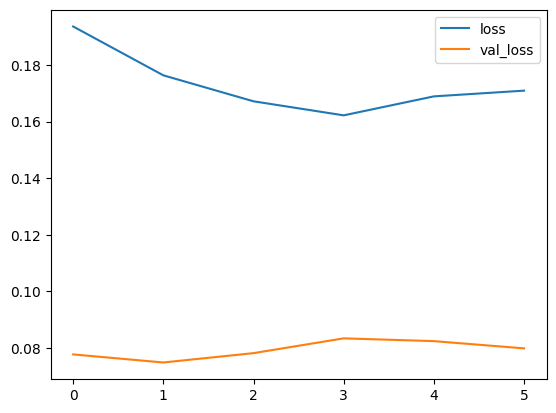

In [ ]:
result=test(model_gcn_lstm,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

### GCN

In [ ]:
model_gcn=GCN(in_channels=X_train.shape[1],hidden_channels=y_train.shape[1],num_layers=1) # ,num_nodes=train_X.shape[2]
model_gcn.to(device)

GCN(3, 1, num_layers=1)

In [ ]:
X_train.shape[1]

3

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_gcn,100)

Epoch: 0, loss: 0.40604 val_loss 0.66893
Epoch: 1, loss: 0.40260 val_loss 0.66403
Epoch: 2, loss: 0.39918 val_loss 0.65915
Epoch: 3, loss: 0.39578 val_loss 0.65430
Epoch: 4, loss: 0.39240 val_loss 0.64946
Epoch: 5, loss: 0.38904 val_loss 0.64465
Epoch: 6, loss: 0.38570 val_loss 0.63986
Epoch: 7, loss: 0.38238 val_loss 0.63509
Epoch: 8, loss: 0.37908 val_loss 0.63035
Epoch: 9, loss: 0.37580 val_loss 0.62563
Epoch: 10, loss: 0.37255 val_loss 0.62094
Epoch: 11, loss: 0.36931 val_loss 0.61627
Epoch: 12, loss: 0.36610 val_loss 0.61162
Epoch: 13, loss: 0.36291 val_loss 0.60700
Epoch: 14, loss: 0.35975 val_loss 0.60240
Epoch: 15, loss: 0.35661 val_loss 0.59783
Epoch: 16, loss: 0.35349 val_loss 0.59329
Epoch: 17, loss: 0.35039 val_loss 0.58877
Epoch: 18, loss: 0.34732 val_loss 0.58428
Epoch: 19, loss: 0.34427 val_loss 0.57982
Epoch: 20, loss: 0.34124 val_loss 0.57538
Epoch: 21, loss: 0.33824 val_loss 0.57098
Epoch: 22, loss: 0.33526 val_loss 0.56660
Epoch: 23, loss: 0.33230 val_loss 0.56224
Ep

In [ ]:
loss

[0.40603920817375183,
 0.4025992751121521,
 0.3991786539554596,
 0.3957776725292206,
 0.3923967182636261,
 0.3890359401702881,
 0.38569581508636475,
 0.3823765218257904,
 0.37907829880714417,
 0.3758016526699066,
 0.37254658341407776,
 0.3693135678768158,
 0.3661027252674103,
 0.3629142642021179,
 0.3597484230995178,
 0.3566054403781891,
 0.35348546504974365,
 0.3503887951374054,
 0.3473154306411743,
 0.34426558017730713,
 0.34123939275741577,
 0.3382370173931122,
 0.3352585434913635,
 0.33230412006378174,
 0.3293738067150116,
 0.32646769285202026,
 0.3235858380794525,
 0.32072824239730835,
 0.3178950548171997,
 0.3150861859321594,
 0.31230172514915466,
 0.3095417022705078,
 0.30680611729621887,
 0.3040948808193207,
 0.3014080822467804,
 0.29874566197395325,
 0.29610753059387207,
 0.29349371790885925,
 0.2909041941165924,
 0.2883387804031372,
 0.2857975363731384,
 0.2832803428173065,
 0.2807871401309967,
 0.2783178687095642,
 0.27587246894836426,
 0.27345070242881775,
 0.27105265855789

In [ ]:
val_loss

[0.6689254641532898,
 0.6640282273292542,
 0.6591516733169556,
 0.654296338558197,
 0.6494623422622681,
 0.6446505784988403,
 0.6398611068725586,
 0.6350946426391602,
 0.6303514838218689,
 0.6256319880485535,
 0.6209368109703064,
 0.6162658929824829,
 0.6116198897361755,
 0.6069990396499634,
 0.6024037599563599,
 0.5978344082832336,
 0.593291163444519,
 0.5887742638587952,
 0.5842841267585754,
 0.5798209309577942,
 0.575384795665741,
 0.570976197719574,
 0.566595196723938,
 0.5622419714927673,
 0.5579168200492859,
 0.5536197423934937,
 0.549350917339325,
 0.5451105237007141,
 0.5408985614776611,
 0.5367151498794556,
 0.5325605273246765,
 0.5284346342086792,
 0.5243374705314636,
 0.5202692151069641,
 0.5162298679351807,
 0.5122193694114685,
 0.5082378387451172,
 0.5042852759361267,
 0.5003615021705627,
 0.4964666962623596,
 0.4926007091999054,
 0.4887636601924896,
 0.48495545983314514,
 0.4811759293079376,
 0.47742506861686707,
 0.47370293736457825,
 0.47000932693481445,
 0.466344177722

test mse	0.1722373217344284
test r2	-3.0045690536499023


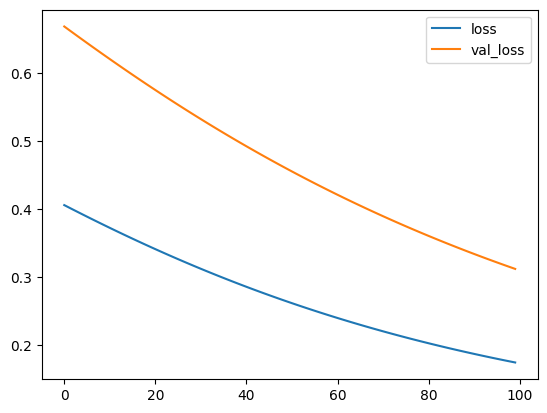

In [ ]:
result=test(model_gcn,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

### LSTM

In [ ]:
model_lstm=LSTM(num_inputs=X_train.shape[1],num_outputs=y_train.shape[1],hidden_size=153) # ,num_nodes=train_X.shape[2]
model_lstm.to(device)

LSTM(
  (lstm): LSTM(3, 153, num_layers=20, batch_first=True)
  (fc): Linear(in_features=153, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_lstm,100)

Epoch: 0, loss: 0.17519 val_loss 0.07643
Epoch: 1, loss: 0.16616 val_loss 0.08007
Epoch: 2, loss: 0.16641 val_loss 0.08233
Epoch: 3, loss: 0.16899 val_loss 0.08093
Epoch: 4, loss: 0.16839 val_loss 0.07913
Epoch: 5, loss: 0.16695 val_loss 0.07808
Epoch: 6, loss: 0.16475 val_loss 0.07770
Epoch: 7, loss: 0.16478 val_loss 0.07764
Early stopping at epoch 7!
CPU times: user 12.3 s, sys: 285 ms, total: 12.6 s
Wall time: 13.7 s


In [ ]:
loss

[0.17518973350524902,
 0.16615894436836243,
 0.16640591621398926,
 0.16898564994335175,
 0.16839037835597992,
 0.16694623231887817,
 0.16475273668766022,
 0.16478107869625092]

In [ ]:
val_loss

[0.07643159478902817,
 0.08006801456212997,
 0.08232860267162323,
 0.08093374222517014,
 0.07913409173488617,
 0.07808224111795425,
 0.07769632339477539,
 0.07763881236314774]

test mse	0.04206136614084244
test r2	0.022060751914978027


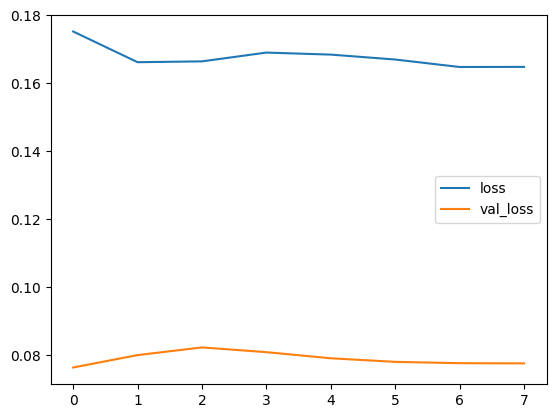

In [ ]:
result=test(model_lstm,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

## sequence statistic

### load_data

In [ ]:
with open("drive/MyDrive/m5/col_seq_HOBBIES_1_004_CA_1_X.pickle", 'rb') as fp:
  X = pickle.load(fp)
  fp.close()
with open("drive/MyDrive/m5/col_seq_HOBBIES_1_004_CA_1_y.pickle", 'rb') as fp:
  y = pickle.load(fp)
  fp.close()

In [ ]:
len(X),len(y)

(1906, 1906)

In [ ]:
(len(X),len(X[0]),len(X[0][0]))

(1906, 28, 3)

In [ ]:

sha=(len(X),len(X[0]),len(X[0][0]))
sc_X = MinMaxScaler(feature_range=(-1, 1))
X=np.array(X).reshape(sha[0],sha[1]*sha[2])
X[:-56]=sc_X.fit_transform(X[:-56])
X[-56:]=sc_X.transform(X[-56:])
X=list(X.reshape(sha[0],sha[1],3))

sc_y = MinMaxScaler(feature_range=(-1, 1))
#y=list(np.array(y).reshape(-1,1))
y[:-56]=sc_y.fit_transform(y[:-56])
y[-56:]=sc_y.transform(y[-56:])
#y=list(np.array(y).reshape(1,-1))


In [ ]:
X_train=torch.FloatTensor(np.array(X[:-56])).to(device)
y_train=torch.FloatTensor(np.array(y[:-56])).to(device)
X_val=torch.FloatTensor(np.array(X[-56:-28])).to(device)
y_val=torch.FloatTensor(np.array(y[-56:-28])).to(device)
X_test=torch.FloatTensor(np.array(X[-28:])).to(device)
y_test=torch.FloatTensor(np.array(y[-28:])).to(device)

In [ ]:
X_train.shape, y_train.shape

(torch.Size([1850, 28, 3]), torch.Size([1850, 1]))

### LSTN_GCN

In [ ]:
model_lstm_gcn=LSTM_GCN(num_inputs=X_train.shape[2],num_outputs=y_train.shape[1],hidden_size=153) # ,num_nodes=train_X.shape[2]
model_lstm_gcn.to(device)

LSTM_GCN(
  (lstm): LSTM(3, 153, num_layers=20, batch_first=True)
  (gcn): GCNConv(153, 153)
  (fc): Linear(in_features=153, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_lstm_gcn,100)

Epoch: 0, loss: 0.16785 val_loss 0.08179
Epoch: 1, loss: 0.15757 val_loss 0.08880
Epoch: 2, loss: 0.15215 val_loss 0.10200
Epoch: 3, loss: 0.15534 val_loss 0.10213
Epoch: 4, loss: 0.15588 val_loss 0.09622
Early stopping at epoch 4!
CPU times: user 3min 15s, sys: 37.3 s, total: 3min 52s
Wall time: 3min 55s


In [ ]:
loss

[0.16785413026809692,
 0.15756897628307343,
 0.15214742720127106,
 0.15534251928329468,
 0.15587934851646423]

In [ ]:
val_loss

[0.0817873626947403,
 0.08879896253347397,
 0.10200227051973343,
 0.10213188081979752,
 0.09621663391590118]

test mse	0.044160664081573486
test r2	-0.02674853801727295


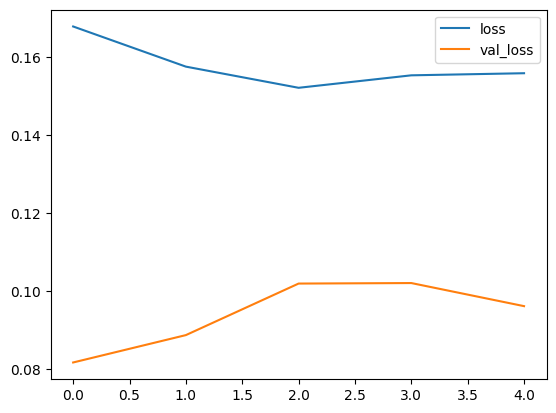

In [ ]:
result=test(model_lstm_gcn,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

### GCN_LSTM

In [ ]:
model_gcn_lstm=GCN_LSTM(num_inputs=X_train.shape[2],num_outputs=y_train.shape[1],hidden_size=153) # ,num_nodes=train_X.shape[2]
model_gcn_lstm.to(device)

GCN_LSTM(
  (gcn): GCNConv(3, 153)
  (lstm): LSTM(153, 153, num_layers=20, batch_first=True)
  (fc): Linear(in_features=153, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_gcn_lstm,100)

Epoch: 0, loss: 0.17075 val_loss 0.08169
Epoch: 1, loss: 0.16013 val_loss 0.08883
Epoch: 2, loss: 0.15831 val_loss 0.09546
Epoch: 3, loss: 0.15826 val_loss 0.09455
Epoch: 4, loss: 0.15561 val_loss 0.09118
Epoch: 5, loss: 0.15757 val_loss 0.08786
Epoch: 6, loss: 0.15637 val_loss 0.08549
Epoch: 7, loss: 0.15669 val_loss 0.08414
Early stopping at epoch 7!
CPU times: user 5min 32s, sys: 1min 4s, total: 6min 36s
Wall time: 6min 38s


In [ ]:
loss

[0.1707485020160675,
 0.1601317971944809,
 0.15831290185451508,
 0.15825951099395752,
 0.1556125432252884,
 0.15756934881210327,
 0.15636591613292694,
 0.15668727457523346]

In [ ]:
val_loss

[0.08168970048427582,
 0.08882956951856613,
 0.09545880556106567,
 0.09454598277807236,
 0.0911802425980568,
 0.08786334097385406,
 0.08549090474843979,
 0.08414094895124435]

test mse	0.0440458282828331
test r2	-0.02407848834991455


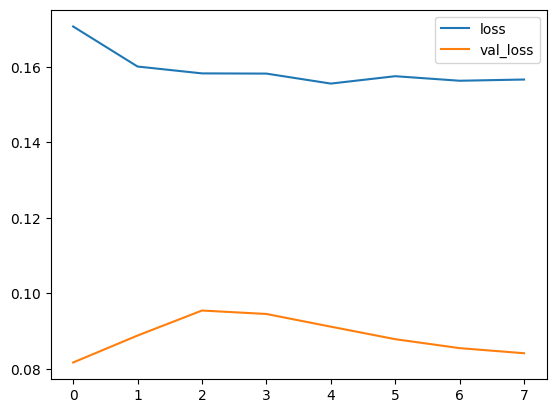

In [ ]:
result=test(model_gcn_lstm,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

### GCN

In [ ]:
model_gcn=GCN_3d(X_train.shape[2],y_train.shape[1],y_train.shape[1]) #GCN(in_channels=X_train.shape[2],hidden_channels=y_train.shape[1],num_layers=1)
model_gcn.to(device)

GCN_3d(
  (conv1): GCNConv(3, 1)
  (fc): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
X_train.shape[1]

28

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_gcn,100)

Epoch: 0, loss: 2.24098 val_loss 1.57585
Epoch: 1, loss: 2.22524 val_loss 1.56258
Epoch: 2, loss: 2.20959 val_loss 1.54940
Epoch: 3, loss: 2.19402 val_loss 1.53629
Epoch: 4, loss: 2.17853 val_loss 1.52327
Epoch: 5, loss: 2.16313 val_loss 1.51033
Epoch: 6, loss: 2.14782 val_loss 1.49747
Epoch: 7, loss: 2.13259 val_loss 1.48469
Epoch: 8, loss: 2.11745 val_loss 1.47200
Epoch: 9, loss: 2.10240 val_loss 1.45940
Epoch: 10, loss: 2.08744 val_loss 1.44688
Epoch: 11, loss: 2.07258 val_loss 1.43444
Epoch: 12, loss: 2.05780 val_loss 1.42210
Epoch: 13, loss: 2.04311 val_loss 1.40984
Epoch: 14, loss: 2.02852 val_loss 1.39766
Epoch: 15, loss: 2.01403 val_loss 1.38558
Epoch: 16, loss: 1.99963 val_loss 1.37358
Epoch: 17, loss: 1.98532 val_loss 1.36168
Epoch: 18, loss: 1.97111 val_loss 1.34986
Epoch: 19, loss: 1.95699 val_loss 1.33813
Epoch: 20, loss: 1.94297 val_loss 1.32649
Epoch: 21, loss: 1.92905 val_loss 1.31494
Epoch: 22, loss: 1.91522 val_loss 1.30348
Epoch: 23, loss: 1.90149 val_loss 1.29211
Ep

In [ ]:
loss

[2.2409794330596924,
 2.225243091583252,
 2.2095890045166016,
 2.1940181255340576,
 2.1785316467285156,
 2.16313099861145,
 2.1478166580200195,
 2.13258957862854,
 2.1174509525299072,
 2.1024017333984375,
 2.0874428749084473,
 2.072575330734253,
 2.0577988624572754,
 2.0431149005889893,
 2.02852463722229,
 2.014028549194336,
 1.9996259212493896,
 1.9853181838989258,
 1.9711062908172607,
 1.9569900035858154,
 1.9429688453674316,
 1.9290452003479004,
 1.9152175188064575,
 1.9014867544174194,
 1.8878529071807861,
 1.874315857887268,
 1.8608763217926025,
 1.847533106803894,
 1.8342872858047485,
 1.8211383819580078,
 1.8080856800079346,
 1.7951297760009766,
 1.782270908355713,
 1.7695074081420898,
 1.756840705871582,
 1.7442691326141357,
 1.7317928075790405,
 1.7194113731384277,
 1.707124948501587,
 1.694932460784912,
 1.682833194732666,
 1.670828104019165,
 1.6589149236679077,
 1.6470947265625,
 1.6353662014007568,
 1.6237291097640991,
 1.6121829748153687,
 1.6007272005081177,
 1.589360952

In [ ]:
val_loss

[1.5758494138717651,
 1.5625847578048706,
 1.5493990182876587,
 1.536293625831604,
 1.5232698917388916,
 1.5103284120559692,
 1.497469186782837,
 1.4846941232681274,
 1.4720033407211304,
 1.4593979120254517,
 1.4468777179718018,
 1.4344435930252075,
 1.4220960140228271,
 1.4098360538482666,
 1.3976640701293945,
 1.3855794668197632,
 1.3735835552215576,
 1.361676573753357,
 1.3498584032058716,
 1.3381288051605225,
 1.3264894485473633,
 1.3149384260177612,
 1.3034780025482178,
 1.2921066284179688,
 1.2808246612548828,
 1.2696324586868286,
 1.2585293054580688,
 1.2475157976150513,
 1.2365905046463013,
 1.2257544994354248,
 1.215006947517395,
 1.2043479681015015,
 1.193777322769165,
 1.1832942962646484,
 1.1728990077972412,
 1.1625903844833374,
 1.1523687839508057,
 1.1422332525253296,
 1.1321837902069092,
 1.122219443321228,
 1.1123400926589966,
 1.1025453805923462,
 1.0928343534469604,
 1.0832067728042603,
 1.0736624002456665,
 1.0642009973526,
 1.0548205375671387,
 1.0455219745635986,
 

test mse	0.7575744986534119
test r2	-16.61383056640625


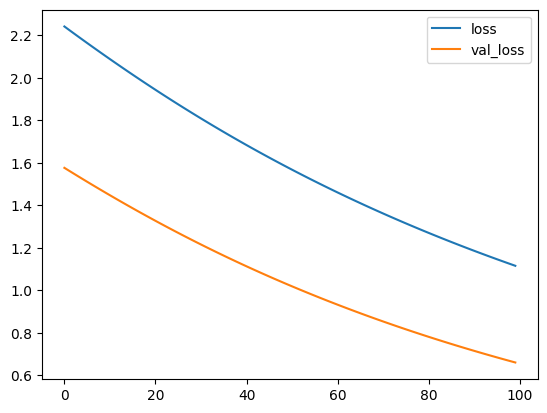

In [ ]:
result=test(model_gcn,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

### LSTM

In [ ]:
model_lstm=LSTM(num_inputs=X_train.shape[2],num_outputs=y_train.shape[1],hidden_size=153) # ,num_nodes=train_X.shape[2]
model_lstm.to(device)

LSTM(
  (lstm): LSTM(3, 153, num_layers=20, batch_first=True)
  (fc): Linear(in_features=153, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_lstm,100)

Epoch: 0, loss: 0.16436 val_loss 0.08333
Epoch: 1, loss: 0.15624 val_loss 0.09192
Epoch: 2, loss: 0.15727 val_loss 0.09533
Epoch: 3, loss: 0.16040 val_loss 0.09241
Epoch: 4, loss: 0.15964 val_loss 0.08882
Epoch: 5, loss: 0.15781 val_loss 0.08615
Epoch: 6, loss: 0.15564 val_loss 0.08459
Epoch: 7, loss: 0.15434 val_loss 0.08395
Epoch: 8, loss: 0.15614 val_loss 0.08381
Early stopping at epoch 8!
CPU times: user 6min 5s, sys: 1min 10s, total: 7min 15s
Wall time: 7min 18s


In [ ]:
loss

[0.1643640249967575,
 0.15624171495437622,
 0.15726709365844727,
 0.1603987216949463,
 0.15963688492774963,
 0.15781375765800476,
 0.15564021468162537,
 0.15433575212955475,
 0.15614041686058044]

In [ ]:
val_loss

[0.08332560211420059,
 0.0919184535741806,
 0.09533263742923737,
 0.09241487085819244,
 0.08881966024637222,
 0.08614597469568253,
 0.0845935121178627,
 0.08395155519247055,
 0.08381340652704239]

test mse	0.044239528477191925
test r2	-0.028582215309143066


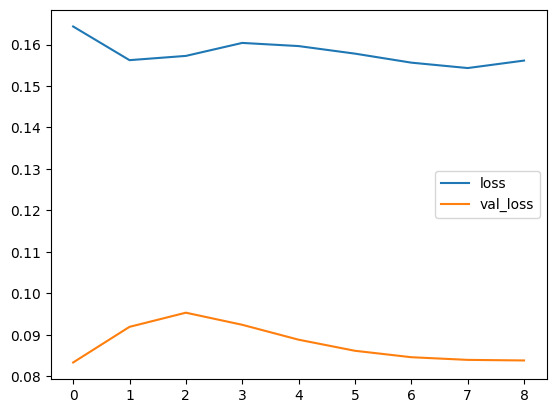

In [ ]:
result=test(model_lstm,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

## sequence

### load data

In [ ]:
with open("drive/MyDrive/m5/seq_HOBBIES_1_004_CA_1_X.pickle", 'rb') as fp:
  X = pickle.load(fp)
  fp.close()
with open("drive/MyDrive/m5/seq_HOBBIES_1_004_CA_1_y.pickle", 'rb') as fp:
  y = pickle.load(fp)
  fp.close()

In [ ]:
len(X),len(y)

(1913, 1913)

In [ ]:
for i in range(len(X)):
  X[i]=list(X[i].astype(float))
  y[i]=float(y[i])

In [ ]:
sc_X = MinMaxScaler(feature_range=(-1, 1))
X[:-56]=sc_X.fit_transform(X[:-56])
X[-56:]=sc_X.transform(X[-56:])

sc_y = MinMaxScaler(feature_range=(-1, 1))
y=list(np.array(y).reshape(-1,1))
y[:-56]=sc_y.fit_transform(y[:-56])
y[-56:]=sc_y.transform(y[-56:])
#y=list(np.array(y).reshape(1,-1))

In [ ]:
for i in range(len(X)):
  X[i]=list(X[i])
  y[i]=list(y[i])

In [ ]:
X_train=torch.FloatTensor(np.array(X[:-56])).to(device)
y_train=torch.FloatTensor(np.array(y[:-56])).to(device)
X_val=torch.FloatTensor(np.array(X[-56:-28])).to(device)
y_val=torch.FloatTensor(np.array(y[-56:-28])).to(device)
X_test=torch.FloatTensor(np.array(X[-28:])).to(device)
y_test=torch.FloatTensor(np.array(y[-28:])).to(device)

In [ ]:
X_train.shape, y_train.shape

(torch.Size([1857, 28]), torch.Size([1857, 1]))

### LSTM_GCN

In [ ]:
model_lstm_gcn=LSTM_GCN(num_inputs=X_train.shape[1],num_outputs=y_train.shape[1],hidden_size=153) # ,num_nodes=train_X.shape[2]
model_lstm_gcn.to(device)

LSTM_GCN(
  (lstm): LSTM(28, 153, num_layers=20, batch_first=True)
  (gcn): GCNConv(153, 153)
  (fc): Linear(in_features=153, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_lstm_gcn,100)

Epoch: 0, loss: 0.72939 val_loss 0.62802
Epoch: 1, loss: 0.63943 val_loss 0.54865
Epoch: 2, loss: 0.54948 val_loss 0.45633
Epoch: 3, loss: 0.44220 val_loss 0.33974
Epoch: 4, loss: 0.29806 val_loss 0.20966
Epoch: 5, loss: 0.14086 val_loss 0.27856
Epoch: 6, loss: 0.51899 val_loss 0.18137
Early stopping at epoch 6!
CPU times: user 9.84 s, sys: 301 ms, total: 10.1 s
Wall time: 10.2 s


In [ ]:
loss

[0.729392409324646,
 0.639432966709137,
 0.5494802594184875,
 0.4421952962875366,
 0.29805999994277954,
 0.14085505902767181,
 0.5189876556396484]

In [ ]:
val_loss

[0.6280182003974915,
 0.5486526489257812,
 0.456326425075531,
 0.33974260091781616,
 0.2096586972475052,
 0.27855581045150757,
 0.1813736855983734]

test mse	0.1393086165189743
test r2	-1.5147428512573242


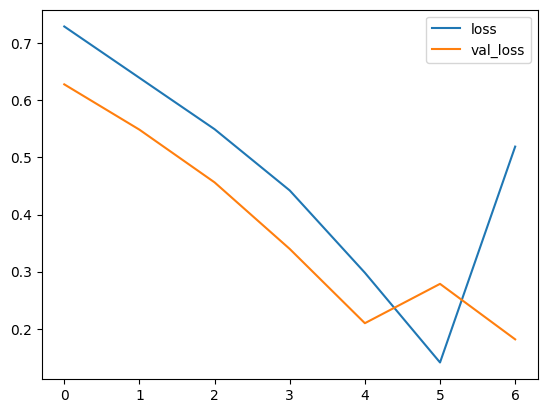

In [ ]:
result=test(model_lstm_gcn,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

### GCN_LSTM

In [ ]:
model_gcn_lstm=GCN_LSTM(num_inputs=X_train.shape[1],num_outputs=y_train.shape[1],hidden_size=153) # ,num_nodes=train_X.shape[2]
model_gcn_lstm.to(device)

GCN_LSTM(
  (gcn): GCNConv(28, 153)
  (lstm): LSTM(153, 153, num_layers=20, batch_first=True)
  (fc): Linear(in_features=153, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_gcn_lstm,100)

Epoch: 0, loss: 0.82274 val_loss 0.70858
Epoch: 1, loss: 0.72547 val_loss 0.62588
Epoch: 2, loss: 0.62854 val_loss 0.53231
Epoch: 3, loss: 0.51503 val_loss 0.41552
Epoch: 4, loss: 0.37527 val_loss 0.26977
Epoch: 5, loss: 0.20006 val_loss 0.27177
Epoch: 6, loss: 0.64475 val_loss 0.20067
Epoch: 7, loss: 0.23129 val_loss 0.23022
Epoch: 8, loss: 0.20142 val_loss 0.26955
Early stopping at epoch 8!
CPU times: user 13.6 s, sys: 498 ms, total: 14.1 s
Wall time: 14.1 s


In [ ]:
loss

[0.8227389454841614,
 0.7254661917686462,
 0.6285395622253418,
 0.5150272250175476,
 0.375266432762146,
 0.2000584751367569,
 0.6447538137435913,
 0.23128990828990936,
 0.20142322778701782]

In [ ]:
val_loss

[0.7085830569267273,
 0.6258772611618042,
 0.5323106050491333,
 0.4155197739601135,
 0.26976531744003296,
 0.2717711627483368,
 0.20066533982753754,
 0.23022055625915527,
 0.2695476710796356]

test mse	0.2567062973976135
test r2	-3.6339588165283203


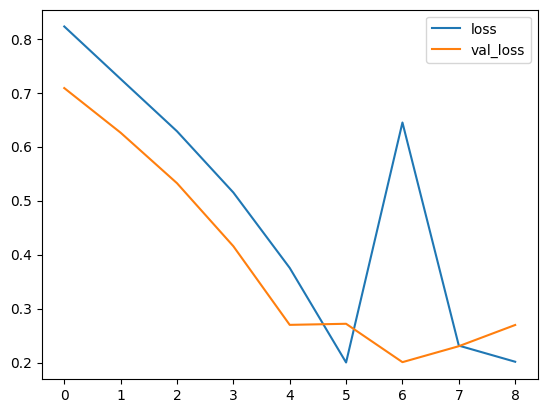

In [ ]:
result=test(model_gcn_lstm,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

### GCN

In [ ]:
model_gcn=GCN(in_channels=X_train.shape[1],hidden_channels=y_train.shape[1],num_layers=1) # ,num_nodes=train_X.shape[2]
model_gcn.to(device)

GCN(28, 1, num_layers=1)

In [ ]:
X_train.shape[1]

28

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_gcn,100)

Epoch: 0, loss: 0.27003 val_loss 0.23226
Epoch: 1, loss: 0.25867 val_loss 0.22340
Epoch: 2, loss: 0.24839 val_loss 0.21551
Epoch: 3, loss: 0.23917 val_loss 0.20859
Epoch: 4, loss: 0.23105 val_loss 0.20266
Epoch: 5, loss: 0.22400 val_loss 0.19767
Epoch: 6, loss: 0.21802 val_loss 0.19362
Epoch: 7, loss: 0.21307 val_loss 0.19045
Epoch: 8, loss: 0.20911 val_loss 0.18811
Epoch: 9, loss: 0.20608 val_loss 0.18651
Epoch: 10, loss: 0.20390 val_loss 0.18557
Epoch: 11, loss: 0.20246 val_loss 0.18518
Epoch: 12, loss: 0.20167 val_loss 0.18522
Epoch: 13, loss: 0.20139 val_loss 0.18558
Epoch: 14, loss: 0.20148 val_loss 0.18612
Epoch: 15, loss: 0.20183 val_loss 0.18675
Epoch: 16, loss: 0.20231 val_loss 0.18736
Epoch: 17, loss: 0.20282 val_loss 0.18787
Epoch: 18, loss: 0.20327 val_loss 0.18824
Epoch: 19, loss: 0.20359 val_loss 0.18842
Early stopping at epoch 19!
CPU times: user 266 ms, sys: 3.73 ms, total: 270 ms
Wall time: 289 ms


In [ ]:
loss

[0.2700275778770447,
 0.258674293756485,
 0.24838502705097198,
 0.23917372524738312,
 0.23104619979858398,
 0.22399863600730896,
 0.21801550686359406,
 0.2130674570798874,
 0.20910950005054474,
 0.2060794085264206,
 0.20389702916145325,
 0.20246461033821106,
 0.20166896283626556,
 0.20138533413410187,
 0.2014833390712738,
 0.20183345675468445,
 0.2023148089647293,
 0.20282168686389923,
 0.2032684087753296,
 0.20359212160110474]

In [ ]:
val_loss

[0.23226238787174225,
 0.22339637577533722,
 0.21550557017326355,
 0.20859374105930328,
 0.2026553601026535,
 0.19767414033412933,
 0.19362092018127441,
 0.19045190513134003,
 0.18810750544071198,
 0.1865113526582718,
 0.18557119369506836,
 0.18518070876598358,
 0.18522322177886963,
 0.18557728826999664,
 0.18612292408943176,
 0.18674877285957336,
 0.18735811114311218,
 0.1878732293844223,
 0.18823811411857605,
 0.18841861188411713]

test mse	0.21323485672473907
test r2	-2.849229574203491


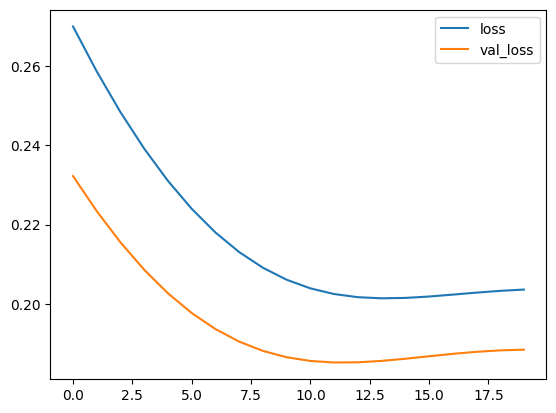

In [ ]:
result=test(model_gcn,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

### LSTM

In [ ]:
model_lstm=LSTM(num_inputs=X_train.shape[1],num_outputs=y_train.shape[1],hidden_size=153) # ,num_nodes=train_X.shape[2]
model_lstm.to(device)

LSTM(
  (lstm): LSTM(28, 153, num_layers=20, batch_first=True)
  (fc): Linear(in_features=153, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_lstm,100)

Epoch: 0, loss: 0.61084 val_loss 0.51354
Epoch: 1, loss: 0.53087 val_loss 0.44812
Epoch: 2, loss: 0.46055 val_loss 0.37897
Epoch: 3, loss: 0.37675 val_loss 0.29906
Epoch: 4, loss: 0.29405 val_loss 0.20661
Epoch: 5, loss: 0.20469 val_loss 0.16942
Epoch: 6, loss: 0.32090 val_loss 0.15237
Epoch: 7, loss: 0.22533 val_loss 0.16313
Early stopping at epoch 7!
CPU times: user 12.2 s, sys: 253 ms, total: 12.4 s
Wall time: 12.5 s


In [ ]:
loss

[0.6108381748199463,
 0.5308677554130554,
 0.46055376529693604,
 0.3767469525337219,
 0.29405468702316284,
 0.2046928107738495,
 0.32089829444885254,
 0.22533108294010162]

In [ ]:
val_loss

[0.5135436058044434,
 0.44811612367630005,
 0.3789731562137604,
 0.29906201362609863,
 0.2066083699464798,
 0.16942386329174042,
 0.15237052738666534,
 0.1631331890821457]

test mse	0.14508412778377533
test r2	-1.6190001964569092


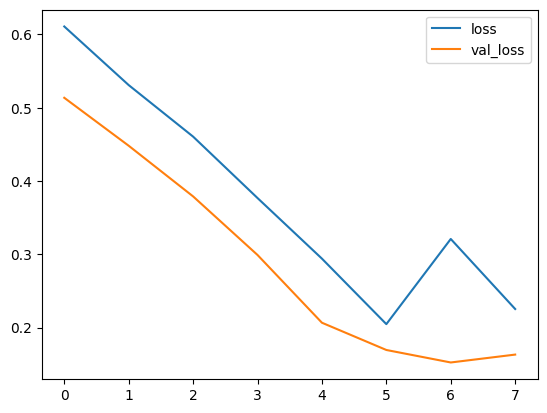

In [ ]:
result=test(model_lstm,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

## stat multiple day

### load data

In [ ]:
X=pd.read_csv("drive/MyDrive/m5/stat_7_HOBBIES_1_004_CA_1.csv")
with open("drive/MyDrive/m5/stat_sales_HOBBIES_1_004_CA_1.pickle", 'rb') as fp:
  y = pickle.load(fp)
  fp.close()

In [ ]:
len(X),len(y)

(1934, 1934)

In [ ]:
i=0
for i in range(len(y)):
  if len(y[i])!=28:
    break


In [ ]:
X=X[:i]
y=y[:i]

In [ ]:
sc_X = MinMaxScaler(feature_range=(-1, 1))
X[:-56]=sc_X.fit_transform(X[:-56])
X[-56:]=sc_X.transform(X[-56:])

In [ ]:
sc_y=MinMaxScaler(feature_range=(-1, 1))
y[:-56]=sc_y.fit_transform(y[:-56])
y[-56:]=sc_y.transform(y[-56:])

In [ ]:
X_train=torch.FloatTensor(np.array(X[:-56])).to(device)
y_train=torch.FloatTensor(np.array(y[:-56])).to(device)
X_val=torch.FloatTensor(np.array(X[-56:-28])).to(device)
y_val=torch.FloatTensor(np.array(y[-56:-28])).to(device)
X_test=torch.FloatTensor(np.array(X[-28:])).to(device)
y_test=torch.FloatTensor(np.array(y[-28:])).to(device)

In [ ]:
X_train.size(),y_train.size()

(torch.Size([1851, 3]), torch.Size([1851, 28]))

### LSTM_GCN

In [ ]:
model_lstm_gcn=LSTM_GCN(num_inputs=X_train.shape[1],num_outputs=y_train.shape[1],hidden_size=153) # ,num_nodes=train_X.shape[2]
model_lstm_gcn.to(device)

LSTM_GCN(
  (lstm): LSTM(3, 153, num_layers=20, batch_first=True)
  (gcn): GCNConv(153, 153)
  (fc): Linear(in_features=153, out_features=28, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_lstm_gcn,100)

Epoch: 0, loss: 0.66562 val_loss 0.59184
Epoch: 1, loss: 0.64374 val_loss 0.57132
Epoch: 2, loss: 0.62033 val_loss 0.54512
Epoch: 3, loss: 0.58996 val_loss 0.50881
Epoch: 4, loss: 0.54595 val_loss 0.45464
Epoch: 5, loss: 0.47619 val_loss 0.36865
Epoch: 6, loss: 0.35726 val_loss 0.24888
Epoch: 7, loss: 0.20117 val_loss 0.19096
Epoch: 8, loss: 0.23950 val_loss 0.17856
Epoch: 9, loss: 0.24247 val_loss 0.15483
Early stopping at epoch 9!
CPU times: user 15.9 s, sys: 169 ms, total: 16.1 s
Wall time: 16.2 s


In [ ]:
loss

[0.6656161546707153,
 0.6437421441078186,
 0.6203281283378601,
 0.5899648070335388,
 0.5459467172622681,
 0.4761897325515747,
 0.3572564423084259,
 0.20116938650608063,
 0.2395007163286209,
 0.24246945977210999]

In [ ]:
val_loss

[0.5918382406234741,
 0.5713186860084534,
 0.5451223850250244,
 0.5088111162185669,
 0.4546370208263397,
 0.36864984035491943,
 0.2488805055618286,
 0.1909591555595398,
 0.1785590946674347,
 0.15483030676841736]

test mse	0.1502411961555481
test r2	-1.3648884296417236


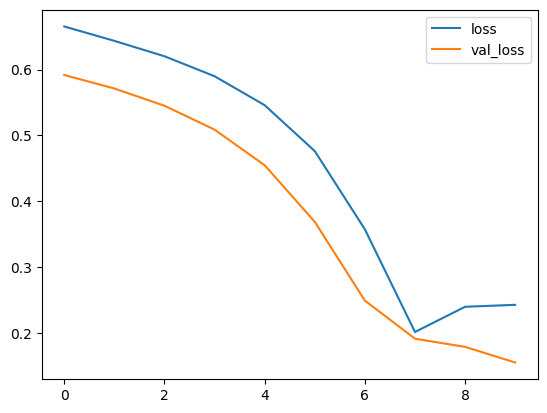

In [ ]:
result=test(model_lstm_gcn,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

In [ ]:
model.predict(X_test,edge_index,batch)

tensor([[-0.1179, -0.0625, -0.1230, -0.0565, -0.1128, -0.0710, -0.1229, -0.0714,
         -0.0117, -0.1229,  0.0186, -0.0112, -0.1206, -0.0642, -0.0258, -0.0110,
         -0.0175, -0.0323, -0.0341, -0.0638, -0.0965,  0.0034, -0.0928, -0.0965,
         -0.0147, -0.0578, -0.0236, -0.0605],
        [-0.1571, -0.1155, -0.1746, -0.0986, -0.1578, -0.1164, -0.1799, -0.1254,
         -0.0661, -0.1742, -0.0274, -0.0800, -0.1745, -0.1090, -0.0704, -0.0470,
         -0.0813, -0.0832, -0.0901, -0.0972, -0.1341, -0.0491, -0.1362, -0.1462,
         -0.0732, -0.1207, -0.0854, -0.0971],
        [-0.2057, -0.1777, -0.2315, -0.1496, -0.2099, -0.1684, -0.2438, -0.1907,
         -0.1316, -0.2332, -0.0835, -0.1623, -0.2361, -0.1607, -0.1218, -0.0920,
         -0.1554, -0.1405, -0.1520, -0.1369, -0.1752, -0.1106, -0.1878, -0.2061,
         -0.1425, -0.1934, -0.1571, -0.1414],
        [-0.2619, -0.2490, -0.2951, -0.2086, -0.2688, -0.2294, -0.3163, -0.2675,
         -0.2057, -0.2996, -0.1497, -0.2555, -0.3067

### GCN_LSTM

In [ ]:
model_gcn_lstm=GCN_LSTM(num_inputs=X_train.shape[1],num_outputs=y_train.shape[1],hidden_size=153) # ,num_nodes=train_X.shape[2]
model_gcn_lstm.to(device)

GCN_LSTM(
  (gcn): GCNConv(3, 153)
  (lstm): LSTM(153, 153, num_layers=20, batch_first=True)
  (fc): Linear(in_features=153, out_features=28, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_gcn_lstm,100)

Epoch: 0, loss: 0.66378 val_loss 0.58879
Epoch: 1, loss: 0.64093 val_loss 0.56719
Epoch: 2, loss: 0.61608 val_loss 0.54147
Epoch: 3, loss: 0.58649 val_loss 0.50711
Epoch: 4, loss: 0.54472 val_loss 0.45539
Epoch: 5, loss: 0.47917 val_loss 0.36999
Epoch: 6, loss: 0.36401 val_loss 0.24913
Epoch: 7, loss: 0.23572 val_loss 0.19349
Epoch: 8, loss: 0.32636 val_loss 0.17413
Epoch: 9, loss: 0.29574 val_loss 0.15974
Epoch: 10, loss: 0.23925 val_loss 0.16062
Early stopping at epoch 10!
CPU times: user 16.6 s, sys: 152 ms, total: 16.7 s
Wall time: 16.8 s


In [ ]:
loss

[0.6637787222862244,
 0.6409339308738708,
 0.6160843372344971,
 0.5864922404289246,
 0.5447243452072144,
 0.47917115688323975,
 0.36400818824768066,
 0.23572023212909698,
 0.32636237144470215,
 0.29574325680732727,
 0.23924556374549866]

In [ ]:
val_loss

[0.5887935161590576,
 0.5671867728233337,
 0.5414662957191467,
 0.5071115493774414,
 0.4553930461406708,
 0.3699930012226105,
 0.2491314709186554,
 0.19349439442157745,
 0.17412765324115753,
 0.15974009037017822,
 0.16061942279338837]

test mse	0.15874506533145905
test r2	-1.5170637369155884


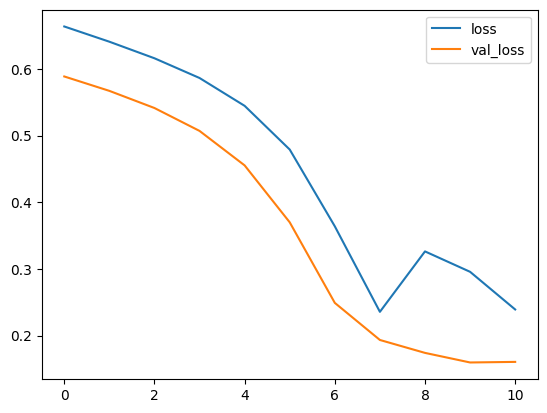

In [ ]:
result=test(model_gcn_lstm,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

### GCN

In [ ]:
model_gcn=GCN(in_channels=X_train.shape[1],hidden_channels=y_train.shape[1],num_layers=1) # ,num_nodes=train_X.shape[2]
model_gcn.to(device)

GCN(3, 28, num_layers=1)

In [ ]:
X_train.shape[1]

3

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_gcn,100)

Epoch: 0, loss: 0.59562 val_loss 0.52989
Epoch: 1, loss: 0.59229 val_loss 0.52679
Epoch: 2, loss: 0.58898 val_loss 0.52370
Epoch: 3, loss: 0.58568 val_loss 0.52063
Epoch: 4, loss: 0.58239 val_loss 0.51756
Epoch: 5, loss: 0.57912 val_loss 0.51452
Epoch: 6, loss: 0.57586 val_loss 0.51148
Epoch: 7, loss: 0.57262 val_loss 0.50846
Epoch: 8, loss: 0.56939 val_loss 0.50545
Epoch: 9, loss: 0.56618 val_loss 0.50246
Epoch: 10, loss: 0.56298 val_loss 0.49949
Epoch: 11, loss: 0.55980 val_loss 0.49652
Epoch: 12, loss: 0.55663 val_loss 0.49358
Epoch: 13, loss: 0.55348 val_loss 0.49065
Epoch: 14, loss: 0.55034 val_loss 0.48773
Epoch: 15, loss: 0.54722 val_loss 0.48483
Epoch: 16, loss: 0.54412 val_loss 0.48195
Epoch: 17, loss: 0.54103 val_loss 0.47908
Epoch: 18, loss: 0.53796 val_loss 0.47622
Epoch: 19, loss: 0.53491 val_loss 0.47339
Epoch: 20, loss: 0.53187 val_loss 0.47057
Epoch: 21, loss: 0.52885 val_loss 0.46776
Epoch: 22, loss: 0.52584 val_loss 0.46497
Epoch: 23, loss: 0.52286 val_loss 0.46220
Ep

In [ ]:
loss

[0.595617413520813,
 0.5922898650169373,
 0.5889759063720703,
 0.5856756567955017,
 0.5823894739151001,
 0.5791175365447998,
 0.5758600831031799,
 0.5726171731948853,
 0.5693891644477844,
 0.5661761164665222,
 0.5629783868789673,
 0.5597959160804749,
 0.5566290020942688,
 0.5534778237342834,
 0.5503425002098083,
 0.5472230911254883,
 0.5441197752952576,
 0.5410326719284058,
 0.5379617810249329,
 0.5349074006080627,
 0.5318694114685059,
 0.5288479924201965,
 0.5258432030677795,
 0.5228551626205444,
 0.519883930683136,
 0.5169294476509094,
 0.5139918923377991,
 0.5110712051391602,
 0.5081676244735718,
 0.5052809119224548,
 0.5024112462997437,
 0.499558687210083,
 0.4967230558395386,
 0.4939045310020447,
 0.49110299348831177,
 0.4883185923099518,
 0.4855511784553528,
 0.4828007221221924,
 0.48006725311279297,
 0.47735080122947693,
 0.4746512174606323,
 0.47196853160858154,
 0.4693026840686798,
 0.4666535556316376,
 0.4640212953090668,
 0.4614056944847107,
 0.4588066637516022,
 0.456224292

In [ ]:
val_loss

[0.5298941731452942,
 0.5267918109893799,
 0.5237026810646057,
 0.5206267833709717,
 0.5175645351409912,
 0.5145159363746643,
 0.5114814043045044,
 0.5084609389305115,
 0.5054548978805542,
 0.5024633407592773,
 0.49948668479919434,
 0.49652495980262756,
 0.49357834458351135,
 0.49064701795578003,
 0.4877311885356903,
 0.48483094573020935,
 0.4819464385509491,
 0.4790777564048767,
 0.4762249290943146,
 0.473388135433197,
 0.47056734561920166,
 0.46776270866394043,
 0.4649742543697357,
 0.46220195293426514,
 0.45944592356681824,
 0.45670607686042786,
 0.45398256182670593,
 0.45127537846565247,
 0.4485844671726227,
 0.4459099769592285,
 0.44325169920921326,
 0.4406098425388336,
 0.4379843473434448,
 0.4353751242160797,
 0.43278226256370544,
 0.43020570278167725,
 0.4276454746723175,
 0.4251014292240143,
 0.42257362604141235,
 0.42006203532218933,
 0.4175666570663452,
 0.41508737206459045,
 0.41262415051460266,
 0.4101770222187042,
 0.4077458679676056,
 0.40533068776130676,
 0.402931332588

test mse	0.2879130244255066
test r2	-3.4699864387512207


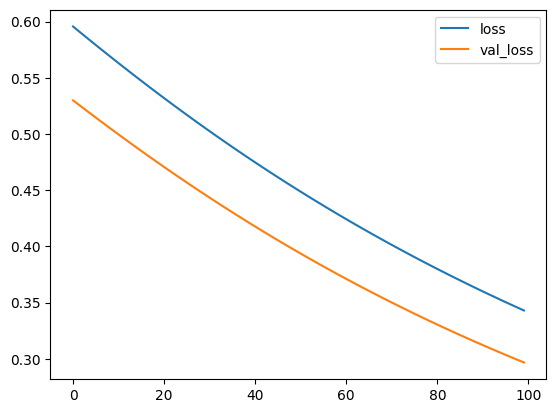

In [ ]:
result=test(model_gcn,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

### LSTM

In [ ]:
model_lstm=LSTM(num_inputs=X_train.shape[1],num_outputs=y_train.shape[1],hidden_size=153) # ,num_nodes=train_X.shape[2]
model_lstm.to(device)

LSTM(
  (lstm): LSTM(3, 153, num_layers=20, batch_first=True)
  (fc): Linear(in_features=153, out_features=28, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_lstm,100)

Epoch: 0, loss: 0.68073 val_loss 0.60355
Epoch: 1, loss: 0.65611 val_loss 0.58022
Epoch: 2, loss: 0.62883 val_loss 0.55259
Epoch: 3, loss: 0.59701 val_loss 0.51615
Epoch: 4, loss: 0.55315 val_loss 0.46277
Epoch: 5, loss: 0.48596 val_loss 0.37785
Epoch: 6, loss: 0.37363 val_loss 0.25950
Epoch: 7, loss: 0.25311 val_loss 0.21012
Epoch: 8, loss: 0.37036 val_loss 0.18548
Epoch: 9, loss: 0.30532 val_loss 0.17372
Epoch: 10, loss: 0.22566 val_loss 0.18376
Epoch: 11, loss: 0.19782 val_loss 0.19944
Epoch: 12, loss: 0.20421 val_loss 0.20749
Early stopping at epoch 12!
CPU times: user 19.6 s, sys: 183 ms, total: 19.7 s
Wall time: 19.9 s


In [ ]:
loss

[0.6807349324226379,
 0.6561122536659241,
 0.6288305521011353,
 0.5970115661621094,
 0.5531487464904785,
 0.48596441745758057,
 0.3736322820186615,
 0.2531072497367859,
 0.37036263942718506,
 0.3053160309791565,
 0.2256643921136856,
 0.19781547784805298,
 0.20421293377876282]

In [ ]:
val_loss

[0.6035467982292175,
 0.5802177786827087,
 0.5525891184806824,
 0.5161508917808533,
 0.46277326345443726,
 0.37784501910209656,
 0.2594960629940033,
 0.21011938154697418,
 0.18547770380973816,
 0.17372144758701324,
 0.18375949561595917,
 0.19944235682487488,
 0.2074907422065735]

test mse	0.20866838097572327
test r2	-2.3177101612091064


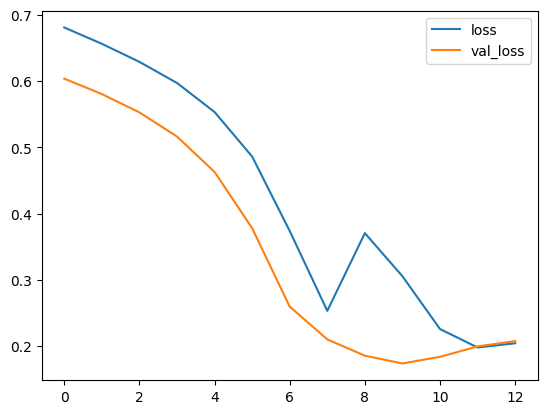

In [ ]:
result=test(model_lstm,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

## stat multiple day sequence

### load_data

In [ ]:
with open("drive/MyDrive/m5/col_mul_seq_HOBBIES_1_004_CA_1_X.pickle", 'rb') as fp:
  X = pickle.load(fp)
  fp.close()
with open("drive/MyDrive/m5/col_mul_seq_HOBBIES_1_004_CA_1_y.pickle", 'rb') as fp:
  y = pickle.load(fp)
  fp.close()

In [ ]:
len(X),len(y)

(1906, 1906)

In [ ]:
i=0
for i in range(len(y)):
  if len(y[i])!=28:
    break


In [ ]:
X=X[:i]
y=y[:i]

In [ ]:
sha=(len(X),len(X[0]),len(X[0][0]))
sc_X = MinMaxScaler(feature_range=(-1, 1))
X=np.array(X).reshape(sha[0],sha[1]*sha[2])
X[:-56]=sc_X.fit_transform(X[:-56])
X[-56:]=sc_X.transform(X[-56:])
X=list(X.reshape(sha[0],sha[1],sha[2]))

In [ ]:
for i in range(len(y)):
  y[i]=np.array(y[i])

In [ ]:
sc_y=MinMaxScaler(feature_range=(-1, 1))
y[:-56]=sc_y.fit_transform(y[:-56])
y[-56:]=sc_y.transform(y[-56:])

In [ ]:
X_train=torch.FloatTensor(np.array(X[:-56])).to(device)
y_train=torch.FloatTensor(np.array(y[:-56])).to(device)
X_val=torch.FloatTensor(np.array(X[-56:-28])).to(device)
y_val=torch.FloatTensor(np.array(y[-56:-28])).to(device)
X_test=torch.FloatTensor(np.array(X[-28:])).to(device)
y_test=torch.FloatTensor(np.array(y[-28:])).to(device)

In [ ]:
X_train.size(),y_train.size()

(torch.Size([1823, 28, 3]), torch.Size([1823, 28]))

### LSTN_GCN

In [ ]:
model_lstm_gcn=LSTM_GCN(num_inputs=X_train.shape[2],num_outputs=y_train.shape[1],hidden_size=153) # ,num_nodes=train_X.shape[2]
model_lstm_gcn.to(device)

LSTM_GCN(
  (lstm): LSTM(3, 153, num_layers=20, batch_first=True)
  (gcn): GCNConv(153, 153)
  (fc): Linear(in_features=153, out_features=28, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_lstm_gcn,100)

Epoch: 0, loss: 0.67419 val_loss 0.60251
Epoch: 1, loss: 0.65240 val_loss 0.58088
Epoch: 2, loss: 0.62981 val_loss 0.55383
Epoch: 3, loss: 0.60189 val_loss 0.51532
Epoch: 4, loss: 0.56198 val_loss 0.45438
Epoch: 5, loss: 0.49959 val_loss 0.35377
Epoch: 6, loss: 0.39628 val_loss 0.20440
Epoch: 7, loss: 0.25019 val_loss 0.11326
Epoch: 8, loss: 0.17994 val_loss 0.14179
Epoch: 9, loss: 0.23276 val_loss 0.12313
Epoch: 10, loss: 0.21304 val_loss 0.08813
Epoch: 11, loss: 0.16869 val_loss 0.06927
Epoch: 12, loss: 0.13751 val_loss 0.07079
Early stopping at epoch 12!
CPU times: user 8min 31s, sys: 1min 34s, total: 10min 5s
Wall time: 10min 17s


In [ ]:
loss

[0.674191951751709,
 0.6523995399475098,
 0.629809558391571,
 0.601889967918396,
 0.5619800090789795,
 0.4995867609977722,
 0.39628171920776367,
 0.2501857578754425,
 0.17994356155395508,
 0.2327595353126526,
 0.21304048597812653,
 0.1686861217021942,
 0.13751062750816345]

In [ ]:
val_loss

[0.602509081363678,
 0.5808809995651245,
 0.5538256764411926,
 0.515317440032959,
 0.4543755054473877,
 0.35376742482185364,
 0.20440351963043213,
 0.11325617879629135,
 0.14178572595119476,
 0.12313445657491684,
 0.08813003450632095,
 0.06926806271076202,
 0.07079122215509415]

test mse	0.07087259739637375
test r2	-0.11861077696084976


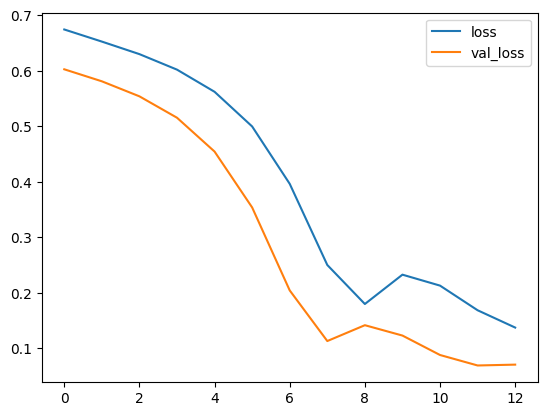

In [ ]:
result=test(model_lstm_gcn,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

### GCN_LSTM

In [ ]:
model_gcn_lstm=GCN_LSTM(num_inputs=X_train.shape[2],num_outputs=y_train.shape[1],hidden_size=153) # ,num_nodes=train_X.shape[2]
model_gcn_lstm.to(device)

GCN_LSTM(
  (gcn): GCNConv(3, 153)
  (lstm): LSTM(153, 153, num_layers=20, batch_first=True)
  (fc): Linear(in_features=153, out_features=28, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_gcn_lstm,100)

Epoch: 0, loss: 0.63501 val_loss 0.56369
Epoch: 1, loss: 0.61225 val_loss 0.53936
Epoch: 2, loss: 0.58756 val_loss 0.50787
Epoch: 3, loss: 0.55524 val_loss 0.46085
Epoch: 4, loss: 0.50769 val_loss 0.38016
Epoch: 5, loss: 0.42901 val_loss 0.24010
Epoch: 6, loss: 0.30106 val_loss 0.11843
Epoch: 7, loss: 0.23974 val_loss 0.10693
Epoch: 8, loss: 0.27931 val_loss 0.08727
Epoch: 9, loss: 0.24813 val_loss 0.07441
Epoch: 10, loss: 0.20980 val_loss 0.08032
Early stopping at epoch 10!
CPU times: user 7min 11s, sys: 1min 16s, total: 8min 28s
Wall time: 8min 31s


In [ ]:
loss

[0.6350079774856567,
 0.6122515797615051,
 0.5875596404075623,
 0.5552352666854858,
 0.5076903104782104,
 0.42900556325912476,
 0.30106106400489807,
 0.2397424578666687,
 0.27931201457977295,
 0.24813023209571838,
 0.2098008096218109]

In [ ]:
val_loss

[0.5636911988258362,
 0.5393583178520203,
 0.5078709125518799,
 0.4608515501022339,
 0.3801625967025757,
 0.24009893834590912,
 0.11843058466911316,
 0.10692593455314636,
 0.08726853132247925,
 0.07440845668315887,
 0.08031677454710007]

test mse	0.08135972172021866
test r2	-0.295990526676178


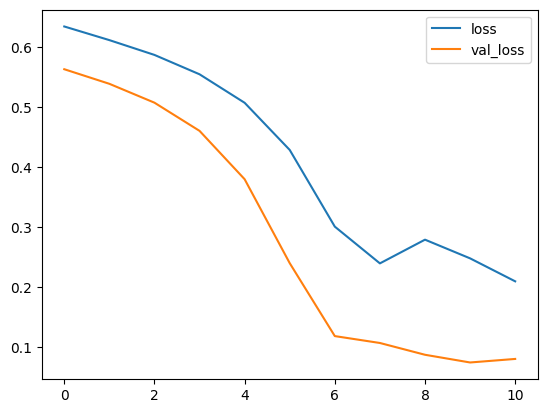

In [ ]:
result=test(model_gcn_lstm,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

### GCN

In [ ]:
model_gcn=GCN_3d(X_train.shape[2],y_train.shape[1],y_train.shape[1]) #GCN(in_channels=X_train.shape[2],hidden_channels=y_train.shape[1],num_layers=1)
model_gcn.to(device)

GCN_3d(
  (conv1): GCNConv(3, 28)
  (fc): Linear(in_features=28, out_features=28, bias=True)
)

In [ ]:
X_train.shape[1]

28

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_gcn,100)

Epoch: 0, loss: 0.72021 val_loss 0.66641
Epoch: 1, loss: 0.70790 val_loss 0.65628
Epoch: 2, loss: 0.69577 val_loss 0.64627
Epoch: 3, loss: 0.68380 val_loss 0.63640
Epoch: 4, loss: 0.67200 val_loss 0.62665
Epoch: 5, loss: 0.66035 val_loss 0.61701
Epoch: 6, loss: 0.64886 val_loss 0.60748
Epoch: 7, loss: 0.63751 val_loss 0.59805
Epoch: 8, loss: 0.62629 val_loss 0.58872
Epoch: 9, loss: 0.61519 val_loss 0.57946
Epoch: 10, loss: 0.60419 val_loss 0.57027
Epoch: 11, loss: 0.59330 val_loss 0.56114
Epoch: 12, loss: 0.58250 val_loss 0.55206
Epoch: 13, loss: 0.57178 val_loss 0.54302
Epoch: 14, loss: 0.56113 val_loss 0.53402
Epoch: 15, loss: 0.55056 val_loss 0.52505
Epoch: 16, loss: 0.54006 val_loss 0.51610
Epoch: 17, loss: 0.52962 val_loss 0.50717
Epoch: 18, loss: 0.51925 val_loss 0.49826
Epoch: 19, loss: 0.50892 val_loss 0.48938
Epoch: 20, loss: 0.49865 val_loss 0.48053
Epoch: 21, loss: 0.48844 val_loss 0.47171
Epoch: 22, loss: 0.47828 val_loss 0.46291
Epoch: 23, loss: 0.46817 val_loss 0.45414
Ep

In [ ]:
loss

[0.7202121019363403,
 0.7079031467437744,
 0.6957695484161377,
 0.6838027238845825,
 0.671999454498291,
 0.6603538990020752,
 0.6488592624664307,
 0.6375068426132202,
 0.6262868046760559,
 0.6151862740516663,
 0.6041939854621887,
 0.5933003425598145,
 0.5824973583221436,
 0.5717765092849731,
 0.5611324310302734,
 0.5505632758140564,
 0.540062427520752,
 0.5296242833137512,
 0.5192451477050781,
 0.5089223384857178,
 0.49865415692329407,
 0.4884398579597473,
 0.4782786965370178,
 0.4681715965270996,
 0.4581173360347748,
 0.4481167495250702,
 0.43817201256752014,
 0.42828530073165894,
 0.41845715045928955,
 0.4086873531341553,
 0.3989832401275635,
 0.3893485367298126,
 0.3797933757305145,
 0.37031689286231995,
 0.36092397570610046,
 0.35161975026130676,
 0.3424094319343567,
 0.33329707384109497,
 0.32429057359695435,
 0.31539255380630493,
 0.30660852789878845,
 0.2979503571987152,
 0.28942394256591797,
 0.28103697299957275,
 0.272794246673584,
 0.26470357179641724,
 0.2567700147628784,
 0

In [ ]:
val_loss

[0.6664050221443176,
 0.6562790274620056,
 0.6462746858596802,
 0.6364006996154785,
 0.6266459226608276,
 0.6170071363449097,
 0.6074782609939575,
 0.5980509519577026,
 0.5887151956558228,
 0.5794597268104553,
 0.570274829864502,
 0.561144232749939,
 0.5520610809326172,
 0.5430200695991516,
 0.5340169668197632,
 0.5250486135482788,
 0.5160966515541077,
 0.5071659684181213,
 0.4982619881629944,
 0.4893840551376343,
 0.4805319309234619,
 0.4717061519622803,
 0.46290674805641174,
 0.454137921333313,
 0.4453984498977661,
 0.4366895258426666,
 0.42800968885421753,
 0.41936150193214417,
 0.4107500910758972,
 0.4021780788898468,
 0.39364856481552124,
 0.3851671814918518,
 0.3767330050468445,
 0.36834943294525146,
 0.36002039909362793,
 0.35175055265426636,
 0.3435508608818054,
 0.33542516827583313,
 0.32737770676612854,
 0.31941306591033936,
 0.31152501702308655,
 0.30371636152267456,
 0.2960006892681122,
 0.28826457262039185,
 0.28063318133354187,
 0.27311328053474426,
 0.2657109200954437,
 

test mse	0.07582848519086838
test r2	-0.18141576647758484


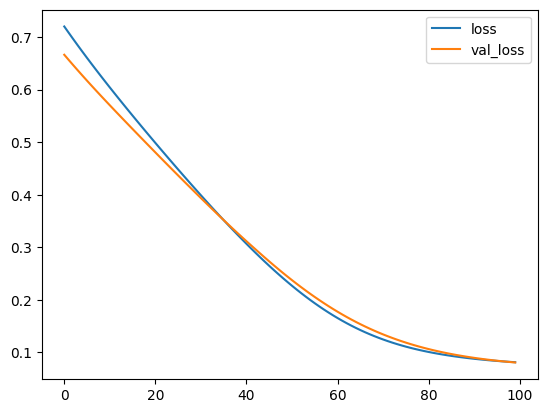

In [ ]:
result=test(model_gcn,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

### LSTM

In [ ]:
model_lstm=LSTM(num_inputs=X_train.shape[2],num_outputs=y_train.shape[1],hidden_size=153) # ,num_nodes=train_X.shape[2]
model_lstm.to(device)

LSTM(
  (lstm): LSTM(3, 153, num_layers=20, batch_first=True)
  (fc): Linear(in_features=153, out_features=28, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_lstm,100)

Epoch: 0, loss: 0.65304 val_loss 0.58223
Epoch: 1, loss: 0.63140 val_loss 0.55996
Epoch: 2, loss: 0.60821 val_loss 0.53295
Epoch: 3, loss: 0.58099 val_loss 0.49558
Epoch: 4, loss: 0.54281 val_loss 0.43631
Epoch: 5, loss: 0.48414 val_loss 0.33151
Epoch: 6, loss: 0.38253 val_loss 0.17343
Epoch: 7, loss: 0.25106 val_loss 0.12277
Epoch: 8, loss: 0.29260 val_loss 0.10547
Epoch: 9, loss: 0.27925 val_loss 0.07978
Epoch: 10, loss: 0.22927 val_loss 0.07264
Epoch: 11, loss: 0.19720 val_loss 0.08409
Early stopping at epoch 11!
CPU times: user 7min 43s, sys: 1min 23s, total: 9min 7s
Wall time: 9min 9s


In [ ]:
loss

[0.6530371904373169,
 0.631402850151062,
 0.6082097887992859,
 0.5809873938560486,
 0.5428062677383423,
 0.4841437041759491,
 0.38252514600753784,
 0.25106316804885864,
 0.2926042973995209,
 0.27924609184265137,
 0.22926847636699677,
 0.19719912111759186]

In [ ]:
val_loss

[0.5822265148162842,
 0.5599625110626221,
 0.5329540371894836,
 0.49558377265930176,
 0.4363062381744385,
 0.3315116763114929,
 0.17342573404312134,
 0.12277068197727203,
 0.10547059029340744,
 0.07977776229381561,
 0.07264090329408646,
 0.08408743143081665]

test mse	0.08520005643367767
test r2	-0.350168377161026


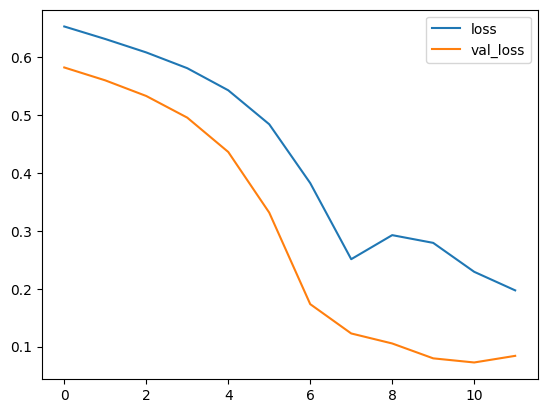

In [ ]:
result=test(model_lstm,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

## seq multiple day

### load_data

In [ ]:
with open("drive/MyDrive/m5/seq_m_HOBBIES_1_004_CA_1_X.pickle", 'rb') as fp:
  X = pickle.load(fp)
  fp.close()
with open("drive/MyDrive/m5/seq_m_HOBBIES_1_004_CA_1_y.pickle", 'rb') as fp:
  y = pickle.load(fp)
  fp.close()

In [ ]:
len(X),len(y)

(1906, 1906)

In [ ]:
len(X),len(X[0]),len(X[0][0])

(1906, 7, 1)

In [ ]:
sha=(len(X),len(X[0]),len(X[0][0]))
sc_X = MinMaxScaler(feature_range=(-1, 1))
X=np.array(X).reshape(sha[0],sha[1]*sha[2])
X[:-56]=sc_X.fit_transform(X[:-56])
X[-56:]=sc_X.transform(X[-56:])
#X=list(X.reshape(sha[0],sha[1],sha[2]))

In [ ]:
len(y),len(y[0]),len(y[0][0])

(1906, 28, 1)

In [ ]:
sha=(len(y),len(y[0]),len(y[0][0]))
sc_y = MinMaxScaler(feature_range=(-1, 1))
y=np.array(y).reshape(sha[0],sha[1]*sha[2])
y[:-56]=sc_y.fit_transform(y[:-56])
y[-56:]=sc_y.transform(y[-56:])
#y=list(y.reshape(sha[0],sha[1],sha[2]))

In [ ]:
len(X),len(X[0])

(1906, 7)

In [ ]:
for i in range(len(X)):
  X[i]=X[i].astype(float)
  y[i]=y[i].astype(float)

In [ ]:
X=X.astype(float)
y=y.astype(float)

In [ ]:
X_train=torch.FloatTensor(np.array(X[:-56])).to(device)
y_train=torch.FloatTensor(np.array(y[:-56])).to(device)
X_val=torch.FloatTensor(np.array(X[-56:-28])).to(device)
y_val=torch.FloatTensor(np.array(y[-56:-28])).to(device)
X_test=torch.FloatTensor(np.array(X[-28:])).to(device)
y_test=torch.FloatTensor(np.array(y[-28:])).to(device)

In [ ]:
X_train.size(),y_train.size()

(torch.Size([1850, 7]), torch.Size([1850, 28]))

### LSTN_GCN

In [ ]:
model_lstm_gcn=LSTM_GCN(num_inputs=X_train.shape[1],num_outputs=y_train.shape[1],hidden_size=153) # ,num_nodes=train_X.shape[2]
model_lstm_gcn.to(device)

LSTM_GCN(
  (lstm): LSTM(7, 153, num_layers=20, batch_first=True)
  (gcn): GCNConv(153, 153)
  (fc): Linear(in_features=153, out_features=28, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_lstm_gcn,100)

Epoch: 0, loss: 0.66410 val_loss 0.59002
Epoch: 1, loss: 0.64215 val_loss 0.57028
Epoch: 2, loss: 0.62005 val_loss 0.54731
Epoch: 3, loss: 0.59352 val_loss 0.51667
Epoch: 4, loss: 0.55706 val_loss 0.47074
Epoch: 5, loss: 0.49849 val_loss 0.39702
Epoch: 6, loss: 0.39651 val_loss 0.28701
Epoch: 7, loss: 0.24540 val_loss 0.19155
Epoch: 8, loss: 0.17326 val_loss 0.17287
Epoch: 9, loss: 0.21320 val_loss 0.15701
Epoch: 10, loss: 0.20073 val_loss 0.13734
Epoch: 11, loss: 0.16675 val_loss 0.12578
Epoch: 12, loss: 0.14117 val_loss 0.12683
Early stopping at epoch 12!
CPU times: user 21 s, sys: 159 ms, total: 21.2 s
Wall time: 21.4 s


In [ ]:
loss

[0.6641001105308533,
 0.6421477794647217,
 0.6200465559959412,
 0.5935178399085999,
 0.5570597052574158,
 0.4984871447086334,
 0.39650994539260864,
 0.24540433287620544,
 0.17326050996780396,
 0.21319842338562012,
 0.20072518289089203,
 0.1667451411485672,
 0.14117176830768585]

In [ ]:
val_loss

[0.5900173783302307,
 0.5702812671661377,
 0.547307014465332,
 0.5166739821434021,
 0.47074493765830994,
 0.3970237970352173,
 0.2870076298713684,
 0.19155316054821014,
 0.17287319898605347,
 0.15700817108154297,
 0.13733595609664917,
 0.12578479945659637,
 0.12683042883872986]

test mse	0.12651978433132172
test r2	-0.9964481592178345


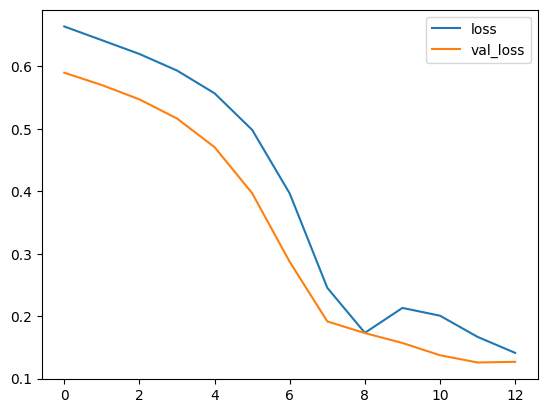

In [ ]:
result=test(model_lstm_gcn,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

### GCN_LSTM

In [ ]:
model_gcn_lstm=GCN_LSTM(num_inputs=X_train.shape[1],num_outputs=y_train.shape[1],hidden_size=153) # ,num_nodes=train_X.shape[2]
model_gcn_lstm.to(device)

GCN_LSTM(
  (gcn): GCNConv(7, 153)
  (lstm): LSTM(153, 153, num_layers=20, batch_first=True)
  (fc): Linear(in_features=153, out_features=28, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_gcn_lstm,100)

Epoch: 0, loss: 0.67799 val_loss 0.60283
Epoch: 1, loss: 0.65545 val_loss 0.58268
Epoch: 2, loss: 0.63236 val_loss 0.55873
Epoch: 3, loss: 0.60379 val_loss 0.52607
Epoch: 4, loss: 0.56355 val_loss 0.47511
Epoch: 5, loss: 0.49549 val_loss 0.38752
Epoch: 6, loss: 0.37101 val_loss 0.26030
Epoch: 7, loss: 0.22412 val_loss 0.18915
Epoch: 8, loss: 0.27837 val_loss 0.17055
Epoch: 9, loss: 0.27843 val_loss 0.15562
Early stopping at epoch 9!
CPU times: user 15.2 s, sys: 125 ms, total: 15.3 s
Wall time: 15.3 s


In [ ]:
loss

[0.6779942512512207,
 0.655447781085968,
 0.6323606967926025,
 0.603789210319519,
 0.5635481476783752,
 0.495493620634079,
 0.3710125684738159,
 0.22411943972110748,
 0.27836665511131287,
 0.2784270644187927]

In [ ]:
val_loss

[0.6028262376785278,
 0.582682728767395,
 0.5587296485900879,
 0.5260697603225708,
 0.47510671615600586,
 0.3875195384025574,
 0.26029878854751587,
 0.189154252409935,
 0.17055486142635345,
 0.15561513602733612]

test mse	0.15321460366249084
test r2	-1.4167814254760742


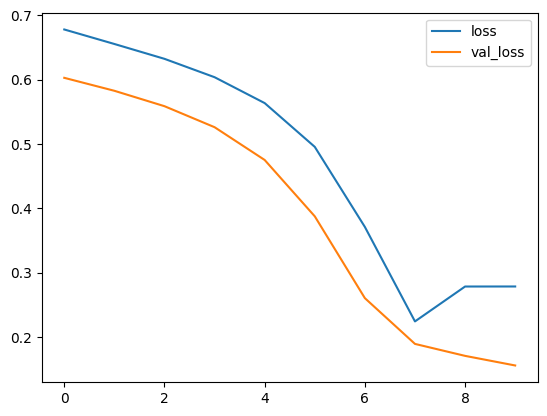

In [ ]:
result=test(model_gcn_lstm,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

### GCN

In [ ]:
model_gcn=GCN(in_channels=X_train.shape[1],hidden_channels=y_train.shape[1],num_layers=1) # ,num_nodes=train_X.shape[2]
model_gcn.to(device)

GCN(7, 28, num_layers=1)

In [ ]:
X_train.shape[1]

7

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_gcn,100)

Epoch: 0, loss: 0.96033 val_loss 0.89027
Epoch: 1, loss: 0.94959 val_loss 0.88002
Epoch: 2, loss: 0.93893 val_loss 0.86987
Epoch: 3, loss: 0.92836 val_loss 0.85980
Epoch: 4, loss: 0.91788 val_loss 0.84982
Epoch: 5, loss: 0.90749 val_loss 0.83994
Epoch: 6, loss: 0.89719 val_loss 0.83014
Epoch: 7, loss: 0.88698 val_loss 0.82044
Epoch: 8, loss: 0.87686 val_loss 0.81082
Epoch: 9, loss: 0.86684 val_loss 0.80131
Epoch: 10, loss: 0.85691 val_loss 0.79188
Epoch: 11, loss: 0.84708 val_loss 0.78255
Epoch: 12, loss: 0.83734 val_loss 0.77331
Epoch: 13, loss: 0.82770 val_loss 0.76417
Epoch: 14, loss: 0.81815 val_loss 0.75512
Epoch: 15, loss: 0.80870 val_loss 0.74617
Epoch: 16, loss: 0.79935 val_loss 0.73731
Epoch: 17, loss: 0.79009 val_loss 0.72855
Epoch: 18, loss: 0.78093 val_loss 0.71988
Epoch: 19, loss: 0.77187 val_loss 0.71130
Epoch: 20, loss: 0.76290 val_loss 0.70282
Epoch: 21, loss: 0.75402 val_loss 0.69443
Epoch: 22, loss: 0.74525 val_loss 0.68613
Epoch: 23, loss: 0.73656 val_loss 0.67793
Ep

In [ ]:
loss

[0.9603314399719238,
 0.9495899081230164,
 0.9389336109161377,
 0.9283642172813416,
 0.9178829193115234,
 0.907491147518158,
 0.8971899747848511,
 0.8869805932044983,
 0.8768638968467712,
 0.8668408393859863,
 0.8569120764732361,
 0.8470784425735474,
 0.8373402953147888,
 0.8276978731155396,
 0.8181517720222473,
 0.8087019920349121,
 0.7993483543395996,
 0.7900913953781128,
 0.7809304594993591,
 0.771865725517273,
 0.7628969550132751,
 0.7540239095687866,
 0.7452462911605835,
 0.7365641593933105,
 0.7279772162437439,
 0.7194851636886597,
 0.7110877633094788,
 0.702785074710846,
 0.6945765018463135,
 0.6864619851112366,
 0.6784412860870361,
 0.6705137491226196,
 0.6626793742179871,
 0.6549375653266907,
 0.6472879648208618,
 0.6397297978401184,
 0.6322628855705261,
 0.6248864531517029,
 0.6175998449325562,
 0.610402524471283,
 0.6032935976982117,
 0.5962725281715393,
 0.5893383622169495,
 0.5824905037879944,
 0.5757280588150024,
 0.5690500736236572,
 0.5624560117721558,
 0.55594474077224

In [ ]:
val_loss

[0.8902658224105835,
 0.880024254322052,
 0.8698695302009583,
 0.8598027229309082,
 0.849824845790863,
 0.839937150478363,
 0.8301404714584351,
 0.8204358816146851,
 0.810823917388916,
 0.8013052940368652,
 0.7918803095817566,
 0.7825495004653931,
 0.7733131051063538,
 0.7641711831092834,
 0.7551238536834717,
 0.7461708784103394,
 0.7373123168945312,
 0.7285479307174683,
 0.7198775410652161,
 0.7113009095191956,
 0.7028177380561829,
 0.6944279670715332,
 0.6861312985420227,
 0.6779276728630066,
 0.669816792011261,
 0.6617985963821411,
 0.6538729071617126,
 0.6460393667221069,
 0.638297975063324,
 0.6306484341621399,
 0.6230903267860413,
 0.6156234741210938,
 0.6082474589347839,
 0.6009617447853088,
 0.5937660932540894,
 0.586659848690033,
 0.5796424746513367,
 0.572713315486908,
 0.5658717751502991,
 0.5591170787811279,
 0.5524485111236572,
 0.5458652973175049,
 0.539366602897644,
 0.5329515337944031,
 0.5266193747520447,
 0.5203690528869629,
 0.5141999125480652,
 0.508110761642456,
 0

test mse	0.2874813675880432
test r2	-3.471193552017212


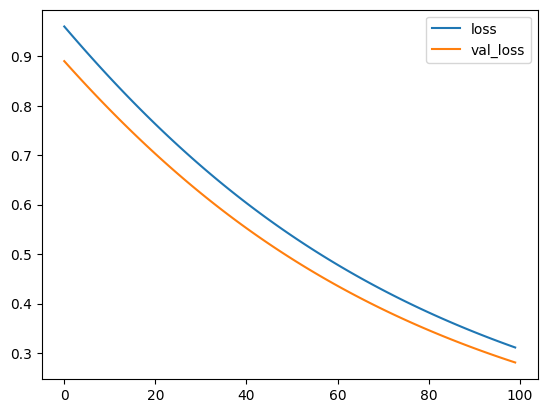

In [ ]:
result=test(model_gcn,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

### LSTM

In [ ]:
model_lstm=LSTM(num_inputs=X_train.shape[1],num_outputs=y_train.shape[1],hidden_size=153) # ,num_nodes=train_X.shape[2]
model_lstm.to(device)

LSTM(
  (lstm): LSTM(7, 153, num_layers=20, batch_first=True)
  (fc): Linear(in_features=153, out_features=28, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_lstm,100)

Epoch: 0, loss: 0.66761 val_loss 0.59079
Epoch: 1, loss: 0.64394 val_loss 0.56849
Epoch: 2, loss: 0.61853 val_loss 0.54151
Epoch: 3, loss: 0.58682 val_loss 0.50471
Epoch: 4, loss: 0.54211 val_loss 0.44818
Epoch: 5, loss: 0.46987 val_loss 0.35537
Epoch: 6, loss: 0.34507 val_loss 0.23784
Epoch: 7, loss: 0.24440 val_loss 0.18918
Epoch: 8, loss: 0.29708 val_loss 0.16878
Epoch: 9, loss: 0.27397 val_loss 0.15671
Epoch: 10, loss: 0.22585 val_loss 0.15932
Early stopping at epoch 10!
CPU times: user 16.4 s, sys: 140 ms, total: 16.6 s
Wall time: 16.7 s


In [ ]:
loss

[0.6676104664802551,
 0.6439352035522461,
 0.6185293197631836,
 0.5868181586265564,
 0.5421139597892761,
 0.4698728621006012,
 0.34506890177726746,
 0.24439629912376404,
 0.29708242416381836,
 0.2739700376987457,
 0.2258501499891281]

In [ ]:
val_loss

[0.590788722038269,
 0.5684880614280701,
 0.5415118336677551,
 0.5047082304954529,
 0.44817647337913513,
 0.3553696572780609,
 0.23784145712852478,
 0.18918058276176453,
 0.1687754988670349,
 0.1567062884569168,
 0.1593189388513565]

test mse	0.16005443036556244
test r2	-1.5287445783615112


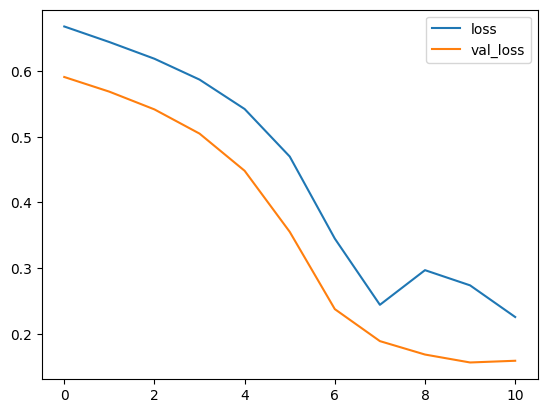

In [ ]:
result=test(model_lstm,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

## sequence for whole items and stores

### load_data

In [ ]:
with open("drive/MyDrive/m5/seq_all_X.pickle", 'rb') as fp:
  X = pickle.load(fp)
  fp.close()
  del fp

with open("drive/MyDrive/m5/seq_all_y.pickle", 'rb') as fp:
  y = pickle.load(fp)
  fp.close()
  del fp

In [ ]:
len(X),len(X[0]),len(X[0][0])

(208, 28, 30490)

In [ ]:
sha=(len(X),len(X[0]),len(X[0][0]))
sc_X = MinMaxScaler(feature_range=(-1, 1))
X=np.array(X).reshape(sha[0]*sha[1],sha[2])
X[:-56]=sc_X.fit_transform(X[:-56])
X[-56:]=sc_X.transform(X[-56:])
X=list(X.reshape(sha[0],sha[1],sha[2]))
del sc_X

In [ ]:
sc_y=MinMaxScaler(feature_range=(-1, 1))
y[:-56]=sc_y.fit_transform(y[:-56])
y[-56:]=sc_y.transform(y[-56:])
del sc_y

In [ ]:
for i in range(len(X)):
  X[i]=X[i].astype(float)
  y[i]=y[i].astype(float)

In [ ]:
X_train=torch.FloatTensor(np.array(X[:-56])).to(device)
y_train=torch.FloatTensor(np.array(y[:-56])).to(device)
X_val=torch.FloatTensor(np.array(X[-56:-28])).to(device)
y_val=torch.FloatTensor(np.array(y[-56:-28])).to(device)
X_test=torch.FloatTensor(np.array(X[-28:])).to(device)
y_test=torch.FloatTensor(np.array(y[-28:])).to(device)

In [ ]:
del X,y

In [ ]:
X_train.size(),y_train.size()

(torch.Size([152, 28, 30490]), torch.Size([152, 30490]))

### LSTN_GCN

In [ ]:
model_lstm_gcn==LSTM_GCN(num_inputs=X_train.shape[2],num_outputs=y_train.shape[1],hidden_size=153) # ,num_nodes=train_X.shape[2]
model_lstm_gcn.to(device)

LSTM_GCN(
  (lstm): LSTM(30490, 153, num_layers=20, batch_first=True)
  (gcn): GCNConv(153, 153)
  (fc): Linear(in_features=153, out_features=30490, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_lstm_gcn,100)

Epoch: 0, loss: 0.71616 val_loss 0.73683
Epoch: 1, loss: 0.71104 val_loss 0.73011
Epoch: 2, loss: 0.70392 val_loss 0.71999
Epoch: 3, loss: 0.69320 val_loss 0.70478
Epoch: 4, loss: 0.67712 val_loss 0.68132
Epoch: 5, loss: 0.65233 val_loss 0.64410
Epoch: 6, loss: 0.61305 val_loss 0.58115
Epoch: 7, loss: 0.54704 val_loss 0.47665
Epoch: 8, loss: 0.43885 val_loss 0.36793
Epoch: 9, loss: 0.33475 val_loss 0.40602
Epoch: 10, loss: 0.39725 val_loss 0.36759
Early stopping at epoch 10!
CPU times: user 4min 2s, sys: 17.1 s, total: 4min 20s
Wall time: 4min 24s


In [ ]:
loss

[0.7161552906036377,
 0.7110385894775391,
 0.703915536403656,
 0.6932008266448975,
 0.6771180033683777,
 0.6523281335830688,
 0.6130464673042297,
 0.5470371246337891,
 0.43885350227355957,
 0.33475005626678467,
 0.39724794030189514]

In [ ]:
val_loss

[0.7368299961090088,
 0.7301112413406372,
 0.7199938893318176,
 0.7047803401947021,
 0.6813241839408875,
 0.6440957188606262,
 0.5811461806297302,
 0.4766486585140228,
 0.36793166399002075,
 0.40601542592048645,
 0.3675903379917145]

test mse	0.917287290096283
test r2	-1.7803564071655273


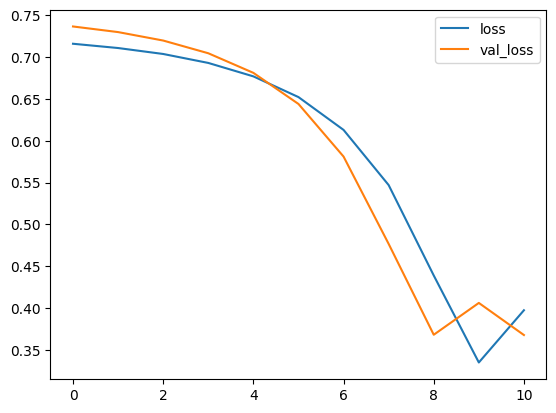

In [ ]:
result=test(model_lstm_gcn,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

### GCN_LSTM

In [ ]:
X_train.shape[2]

30490

In [ ]:
model_gcn_lstm=GCN_LSTM(num_inputs=X_train.shape[2],num_outputs=y_train.shape[1],hidden_size=153) # ,num_nodes=train_X.shape[2]
model_gcn_lstm.to(device)

GCN_LSTM(
  (gcn): GCNConv(30490, 153)
  (lstm): LSTM(153, 153, num_layers=20, batch_first=True)
  (fc): Linear(in_features=153, out_features=30490, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_gcn_lstm,100)

Epoch: 0, loss: 0.71649 val_loss 0.73402
Epoch: 1, loss: 0.70861 val_loss 0.72518
Epoch: 2, loss: 0.69927 val_loss 0.71309
Epoch: 3, loss: 0.68649 val_loss 0.69597
Epoch: 4, loss: 0.66854 val_loss 0.67028
Epoch: 5, loss: 0.64173 val_loss 0.62870
Epoch: 6, loss: 0.59874 val_loss 0.55656
Epoch: 7, loss: 0.52616 val_loss 0.44142
Epoch: 8, loss: 0.41952 val_loss 0.35074
Epoch: 9, loss: 0.37182 val_loss 0.33863
Epoch: 10, loss: 0.39297 val_loss 0.31279
Epoch: 11, loss: 0.36007 val_loss 0.29115
Epoch: 12, loss: 0.31864 val_loss 0.28509
Epoch: 13, loss: 0.29585 val_loss 0.28878
Early stopping at epoch 13!
CPU times: user 1min 24s, sys: 7.58 s, total: 1min 31s
Wall time: 1min 34s


In [ ]:
loss

[0.7164921164512634,
 0.708605945110321,
 0.6992716789245605,
 0.6864902973175049,
 0.6685439944267273,
 0.6417300701141357,
 0.5987439155578613,
 0.5261595249176025,
 0.4195161759853363,
 0.371817946434021,
 0.39297059178352356,
 0.3600669801235199,
 0.31864336133003235,
 0.2958519756793976]

In [ ]:
val_loss

[0.7340209484100342,
 0.7251808047294617,
 0.7130948901176453,
 0.6959686279296875,
 0.6702780723571777,
 0.628703773021698,
 0.5565569996833801,
 0.44141536951065063,
 0.35073643922805786,
 0.33862894773483276,
 0.3127918839454651,
 0.2911452054977417,
 0.2850862145423889,
 0.288776159286499]

test mse	0.8225786089897156
test r2	-1.7860854864120483


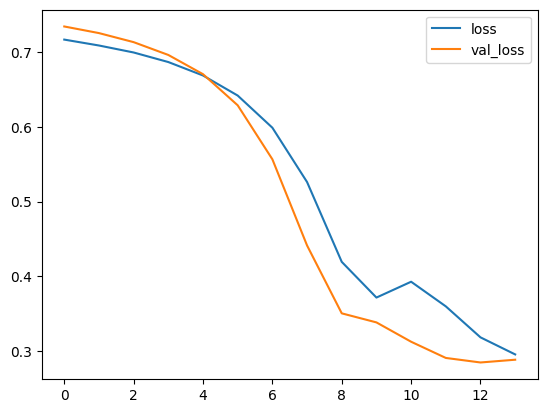

In [ ]:
result=test(model_gcn_lstm,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

### GCN (memory error)

In [ ]:
model_gcn=GCN_3d(X_train.shape[2],y_train.shape[1],y_train.shape[1]) #GCN(in_channels=X_train.shape[2],hidden_channels=y_train.shape[1],num_layers=1)
model_gcn.to(device)

GCN_3d(
  (conv1): GCNConv(30490, 30490)
  (fc): Linear(in_features=30490, out_features=30490, bias=True)
)

In [ ]:
X_train.shape[1]

28

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_gcn,100)

In [ ]:
loss

In [ ]:
val_loss

In [ ]:
result=test(model_gcn,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

### LSTM

In [ ]:
model_lstm=LSTM(num_inputs=X_train.shape[2],num_outputs=y_train.shape[1],hidden_size=153) # ,num_nodes=train_X.shape[2]
model_lstm.to(device)

LSTM(
  (lstm): LSTM(30490, 153, num_layers=20, batch_first=True)
  (fc): Linear(in_features=153, out_features=30490, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_lstm,100)

Epoch: 0, loss: 0.71705 val_loss 0.73560
Epoch: 1, loss: 0.71011 val_loss 0.72807
Epoch: 2, loss: 0.70212 val_loss 0.71783
Epoch: 3, loss: 0.69132 val_loss 0.70340
Epoch: 4, loss: 0.67616 val_loss 0.68202
Epoch: 5, loss: 0.65376 val_loss 0.64782
Epoch: 6, loss: 0.61828 val_loss 0.58744
Epoch: 7, loss: 0.55672 val_loss 0.47984
Epoch: 8, loss: 0.45296 val_loss 0.36158
Epoch: 9, loss: 0.36610 val_loss 0.34925
Epoch: 10, loss: 0.41201 val_loss 0.32352
Epoch: 11, loss: 0.38133 val_loss 0.29515
Epoch: 12, loss: 0.33138 val_loss 0.28402
Epoch: 13, loss: 0.29952 val_loss 0.28688
Early stopping at epoch 13!
CPU times: user 6min 15s, sys: 12 s, total: 6min 27s
Wall time: 6min 32s


In [ ]:
loss

[0.7170546054840088,
 0.7101093530654907,
 0.7021183371543884,
 0.6913180947303772,
 0.6761624813079834,
 0.6537567377090454,
 0.6182817816734314,
 0.5567178130149841,
 0.4529551863670349,
 0.36609795689582825,
 0.4120074212551117,
 0.3813345432281494,
 0.3313849866390228,
 0.29951906204223633]

In [ ]:
val_loss

[0.7356018424034119,
 0.7280710935592651,
 0.7178296446800232,
 0.7033963799476624,
 0.6820212006568909,
 0.6478157639503479,
 0.5874383449554443,
 0.4798418879508972,
 0.3615776002407074,
 0.3492463529109955,
 0.32352176308631897,
 0.2951461672782898,
 0.2840161919593811,
 0.28687724471092224]

test mse	0.8208243250846863
test r2	-1.6833666563034058


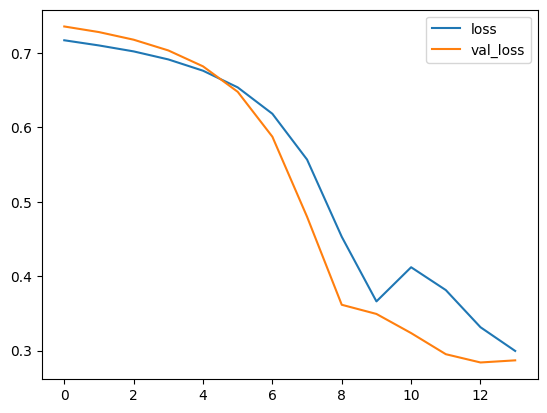

In [ ]:
result=test(model_lstm,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

## sequence and output multiple days’  prediction for whole items and stores

### load_data

In [ ]:
with open("drive/MyDrive/m5/seq_m_all_X_3m.pickle", 'rb') as fp:
  X = pickle.load(fp)
  fp.close()

with open("drive/MyDrive/m5/seq_m_all_y_3m.pickle", 'rb') as fp:
  y = pickle.load(fp)
  fp.close()

In [ ]:
len(X),len(X[0]),len(X[0][0])

(90, 28, 30490)

In [ ]:
#X=X[:30]
#y=y[:30]

In [ ]:
sha=(len(X),len(X[0]),len(X[0][0]))
sc_X = MinMaxScaler(feature_range=(-1, 1))
X=np.array(X).reshape(sha[0]*sha[1],sha[2])
X[:-56]=sc_X.fit_transform(X[:-56])
X[-56:]=sc_X.transform(X[-56:])
X=list(X.reshape(sha[0],sha[1],sha[2]))
del sc_X

In [ ]:
len(y),len(y[0]),len(y[0][0])

(90, 28, 30490)

In [ ]:
sha=(len(y),len(y[0]),len(y[0][0]))
sc_y = MinMaxScaler(feature_range=(-1, 1))
y=np.array(y).reshape(sha[0],sha[1]*sha[2])
y[:-56]=sc_y.fit_transform(y[:-56])
y[-56:]=sc_y.transform(y[-56:])
#y=list(y.reshape(sha[0],sha[1],sha[2]))
del sc_y

In [ ]:
for i in range(len(X)):
  X[i]=X[i].astype(float)
  y[i]=y[i].astype(float)

In [ ]:
y=y.astype(float)

In [ ]:
X_train=torch.FloatTensor(np.array(X[:-56])).to(device)
y_train=torch.FloatTensor(np.array(y[:-56])).to(device)
X_val=torch.FloatTensor(np.array(X[-56:-28])).to(device)
y_val=torch.FloatTensor(np.array(y[-56:-28])).to(device)
X_test=torch.FloatTensor(np.array(X[-28:])).to(device)
y_test=torch.FloatTensor(np.array(y[-28:])).to(device)

In [ ]:
X_train.size(),y_train.size()

(torch.Size([34, 28, 30490]), torch.Size([34, 853720]))

In [ ]:
import psutil

# Getting % usage of virtual_memory ( 3rd field)
print('RAM memory % used:', psutil.virtual_memory()[2])
# Getting usage of virtual_memory in GB ( 4th field)
print('RAM Used (GB):', psutil.virtual_memory()[3]/1000000000)

RAM memory % used: 25.9
RAM Used (GB): 3.206930432


### LSTN_GCN

In [ ]:
model_lstm_gcn=LSTM_GCN(num_inputs=X_train.shape[2],num_outputs=y_train.shape[1],hidden_size=153) # ,num_nodes=train_X.shape[2]
model_lstm_gcn.to(device)

LSTM_GCN(
  (lstm): LSTM(30490, 153, num_layers=20, batch_first=True)
  (gcn): GCNConv(153, 153)
  (fc): Linear(in_features=153, out_features=853720, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_lstm_gcn,100)

Epoch: 0, loss: 0.70998 val_loss 1.52817
Epoch: 1, loss: 0.70841 val_loss 1.52697
Epoch: 2, loss: 0.70705 val_loss 1.52581
Epoch: 3, loss: 0.70575 val_loss 1.52463
Epoch: 4, loss: 0.70443 val_loss 1.52341
Epoch: 5, loss: 0.70306 val_loss 1.52211
Epoch: 6, loss: 0.70159 val_loss 1.52068
Epoch: 7, loss: 0.69996 val_loss 1.51904
Epoch: 8, loss: 0.69808 val_loss 1.51703
Epoch: 9, loss: 0.69578 val_loss 1.51444
Epoch: 10, loss: 0.69280 val_loss 1.51085
Epoch: 11, loss: 0.68865 val_loss 1.50554
Epoch: 12, loss: 0.68246 val_loss 1.49712
Epoch: 13, loss: 0.67269 val_loss 1.48312
Epoch: 14, loss: 0.65631 val_loss 1.45996
Epoch: 15, loss: 0.62907 val_loss 1.42620
Epoch: 16, loss: 0.58896 val_loss 1.38755
Epoch: 17, loss: 0.54198 val_loss 1.35129
Epoch: 18, loss: 0.49669 val_loss 1.31110
Epoch: 19, loss: 0.44826 val_loss 1.27331
Epoch: 20, loss: 0.40327 val_loss 1.24444
Epoch: 21, loss: 0.36873 val_loss 1.22599
Epoch: 22, loss: 0.34593 val_loss 1.21648
Epoch: 23, loss: 0.33319 val_loss 1.21348
Ep

In [ ]:
loss

[0.7099822163581848,
 0.7084095478057861,
 0.7070494294166565,
 0.7057484984397888,
 0.7044289112091064,
 0.703060507774353,
 0.7015901207923889,
 0.6999601125717163,
 0.6980820894241333,
 0.6957834959030151,
 0.6927985548973083,
 0.6886496543884277,
 0.6824591755867004,
 0.6726856231689453,
 0.6563055515289307,
 0.6290732026100159,
 0.5889578461647034,
 0.5419787764549255,
 0.496686190366745,
 0.4482564628124237,
 0.40327128767967224,
 0.3687301278114319,
 0.34592747688293457,
 0.3331869840621948,
 0.3278709053993225,
 0.327152281999588]

In [ ]:
val_loss

[1.5281715393066406,
 1.5269651412963867,
 1.5258084535598755,
 1.5246331691741943,
 1.5234119892120361,
 1.5221129655838013,
 1.5206832885742188,
 1.519038200378418,
 1.517034649848938,
 1.5144388675689697,
 1.5108513832092285,
 1.5055376291275024,
 1.497121810913086,
 1.4831160306930542,
 1.4599583148956299,
 1.426203966140747,
 1.3875471353530884,
 1.3512892723083496,
 1.3110988140106201,
 1.2733055353164673,
 1.2444403171539307,
 1.2259869575500488,
 1.21648371219635,
 1.213480830192566,
 1.2142019271850586,
 1.2162336111068726]

test mse	2.4972288608551025
test r2	-0.9624069333076477


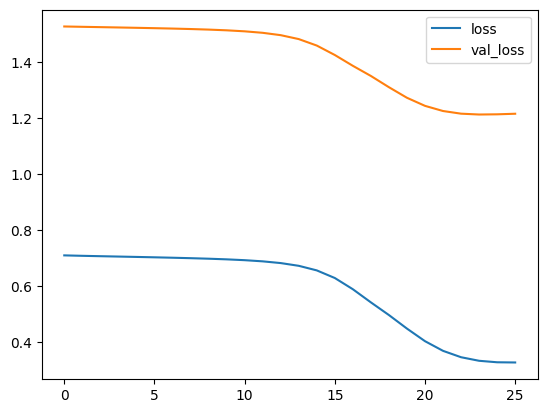

In [ ]:
result=test(model_lstm_gcn,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

### GCN_LSTM

In [ ]:
model_gcn_lstm=GCN_LSTM(num_inputs=X_train.shape[2],num_outputs=y_train.shape[1],hidden_size=153) # ,num_nodes=train_X.shape[2]
model_gcn_lstm.to(device)

GCN_LSTM(
  (gcn): GCNConv(30490, 153)
  (lstm): LSTM(153, 153, num_layers=20, batch_first=True)
  (fc): Linear(in_features=153, out_features=853720, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_gcn_lstm,100)

Epoch: 0, loss: 0.71023 val_loss 1.52814
Epoch: 1, loss: 0.70849 val_loss 1.52679
Epoch: 2, loss: 0.70696 val_loss 1.52551
Epoch: 3, loss: 0.70551 val_loss 1.52423
Epoch: 4, loss: 0.70408 val_loss 1.52292
Epoch: 5, loss: 0.70260 val_loss 1.52152
Epoch: 6, loss: 0.70102 val_loss 1.52000
Epoch: 7, loss: 0.69931 val_loss 1.51829
Epoch: 8, loss: 0.69737 val_loss 1.51626
Epoch: 9, loss: 0.69507 val_loss 1.51371
Epoch: 10, loss: 0.69218 val_loss 1.51026
Epoch: 11, loss: 0.68827 val_loss 1.50517
Epoch: 12, loss: 0.68246 val_loss 1.49696
Epoch: 13, loss: 0.67323 val_loss 1.48288
Epoch: 14, loss: 0.65752 val_loss 1.45971
Epoch: 15, loss: 0.63204 val_loss 1.42753
Epoch: 16, loss: 0.59768 val_loss 1.38933
Epoch: 17, loss: 0.55774 val_loss 1.34768
Epoch: 18, loss: 0.51438 val_loss 1.30636
Epoch: 19, loss: 0.47134 val_loss 1.27018
Epoch: 20, loss: 0.43340 val_loss 1.24239
Epoch: 21, loss: 0.40448 val_loss 1.22405
Epoch: 22, loss: 0.38561 val_loss 1.21423
Epoch: 23, loss: 0.37525 val_loss 1.21081
Ep

In [ ]:
loss

[0.7102344036102295,
 0.7084930539131165,
 0.70695960521698,
 0.70550936460495,
 0.704079270362854,
 0.7025976181030273,
 0.7010197639465332,
 0.699313759803772,
 0.6973701119422913,
 0.6950657367706299,
 0.6921786665916443,
 0.6882742047309875,
 0.6824631690979004,
 0.6732325553894043,
 0.6575232744216919,
 0.6320386528968811,
 0.5976763367652893,
 0.5577386617660522,
 0.5143831968307495,
 0.4713387191295624,
 0.43340227007865906,
 0.404478520154953,
 0.38560760021209717,
 0.3752455413341522,
 0.37100937962532043,
 0.37019026279449463]

In [ ]:
val_loss

[1.5281404256820679,
 1.526788353919983,
 1.5255094766616821,
 1.5242335796356201,
 1.5229161977767944,
 1.5215210914611816,
 1.5200024843215942,
 1.518288016319275,
 1.516258716583252,
 1.5137085914611816,
 1.5102570056915283,
 1.50516676902771,
 1.4969606399536133,
 1.4828771352767944,
 1.4597067832946777,
 1.4275250434875488,
 1.3893296718597412,
 1.347675085067749,
 1.3063589334487915,
 1.2701762914657593,
 1.2423925399780273,
 1.2240495681762695,
 1.2142322063446045,
 1.2108136415481567,
 1.2114229202270508,
 1.2141374349594116]

test mse	2.4884300231933594
test r2	-1.0406289100646973


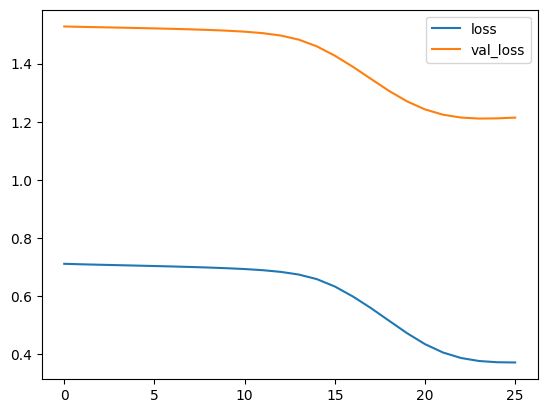

In [ ]:
result=test(model_gcn_lstm,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

### GCN (memory error)

In [ ]:
model_gcn=GCN_3d(X_train.shape[2],y_train.shape[1],y_train.shape[1])
model_gcn.to(device)

In [ ]:
X_train.shape[1]

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_gcn,100)

In [ ]:
loss

In [ ]:
val_loss

In [ ]:
result=test(model_gcn,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)

### LSTM

In [ ]:
model_lstm=LSTM(num_inputs=X_train.shape[2],num_outputs=y_train.shape[1],hidden_size=153) # ,num_nodes=train_X.shape[2]
model_lstm.to(device)

LSTM(
  (lstm): LSTM(30490, 153, num_layers=20, batch_first=True)
  (fc): Linear(in_features=153, out_features=853720, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
%%time
model,loss,val_loss,edge_index,batch=train_test(model_lstm,100)

Epoch: 0, loss: 0.71066 val_loss 1.52817
Epoch: 1, loss: 0.70874 val_loss 1.52675
Epoch: 2, loss: 0.70714 val_loss 1.52541
Epoch: 3, loss: 0.70560 val_loss 1.52408
Epoch: 4, loss: 0.70411 val_loss 1.52270
Epoch: 5, loss: 0.70257 val_loss 1.52125
Epoch: 6, loss: 0.70092 val_loss 1.51966
Epoch: 7, loss: 0.69914 val_loss 1.51787
Epoch: 8, loss: 0.69711 val_loss 1.51574
Epoch: 9, loss: 0.69471 val_loss 1.51305
Epoch: 10, loss: 0.69166 val_loss 1.50940
Epoch: 11, loss: 0.68754 val_loss 1.50404
Epoch: 12, loss: 0.68151 val_loss 1.49547
Epoch: 13, loss: 0.67188 val_loss 1.48099
Epoch: 14, loss: 0.65575 val_loss 1.45749
Epoch: 15, loss: 0.63005 val_loss 1.42518
Epoch: 16, loss: 0.59550 val_loss 1.38726
Epoch: 17, loss: 0.55572 val_loss 1.34625
Epoch: 18, loss: 0.51296 val_loss 1.30562
Epoch: 19, loss: 0.47054 val_loss 1.26999
Epoch: 20, loss: 0.43339 val_loss 1.24258
Epoch: 21, loss: 0.40505 val_loss 1.22433
Epoch: 22, loss: 0.38636 val_loss 1.21429
Epoch: 23, loss: 0.37603 val_loss 1.21052
Ep

In [ ]:
loss

[0.7106584310531616,
 0.708735466003418,
 0.7071412205696106,
 0.705601155757904,
 0.7041113972663879,
 0.7025656700134277,
 0.7009226083755493,
 0.6991395354270935,
 0.697113037109375,
 0.6947062015533447,
 0.6916600465774536,
 0.6875422596931458,
 0.6815057396888733,
 0.6718755960464478,
 0.6557543873786926,
 0.6300503611564636,
 0.5955014228820801,
 0.5557156205177307,
 0.5129589438438416,
 0.4705350995063782,
 0.43339234590530396,
 0.4050478935241699,
 0.3863639831542969,
 0.3760349154472351,
 0.37162283062934875,
 0.37059086561203003]

In [ ]:
val_loss

[1.5281715393066406,
 1.5267454385757446,
 1.5254114866256714,
 1.524079442024231,
 1.5227031707763672,
 1.5212466716766357,
 1.5196607112884521,
 1.5178664922714233,
 1.515735149383545,
 1.513045310974121,
 1.5093986988067627,
 1.5040371417999268,
 1.4954729080200195,
 1.480993390083313,
 1.4574922323226929,
 1.4251781702041626,
 1.3872644901275635,
 1.346251368522644,
 1.3056203126907349,
 1.2699929475784302,
 1.2425845861434937,
 1.2243281602859497,
 1.2142943143844604,
 1.2105211019515991,
 1.2107694149017334,
 1.2131659984588623]

test mse	2.489380121231079
test r2	-0.9912919402122498


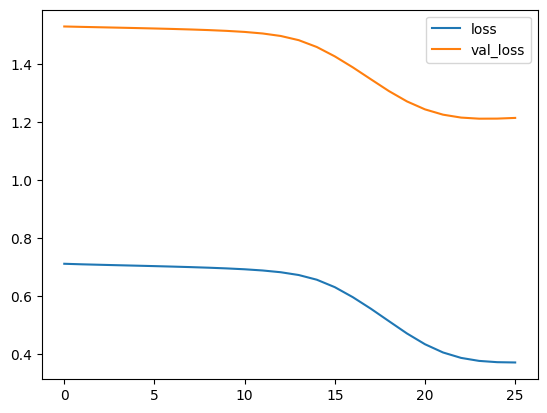

In [ ]:
result=test(model_lstm,edge_index,batch)
print("test mse\t{}\ntest r2\t{}".format(result[0],result[1]))
loss_plot(loss,val_loss)